# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Logistic Regression

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y = data['Score'].values
X_no_stop = data['New_Text'].values
X_summary = data ['Summary'].values

X_no_stop_train, X_no_stop_test, y_train, y_test = train_test_split(X_no_stop, Y, test_size=0.33, shuffle=False)
X_no_stop_train, X_no_stop_CV, y_train, y_CV = train_test_split(X_no_stop_train, y_train, test_size=0.33, shuffle=False)

X_summary_train,X_summary_test, y_summary_train, y_summary_test = train_test_split(X_summary, Y, test_size=0.33, shuffle=False)
X_summary_train,X_summary_CV, y_summary_train, y_summary_CV = train_test_split(X_summary_train,y_summary_train, test_size=0.33, shuffle=False)


## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [3]:
%time
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=9000)
bow_X_train_no_stop = bow_vect.fit_transform(X_no_stop_train)
bow_X_test_no_stop = bow_vect.transform(X_no_stop_test)
bow_X_CV_no_stop = bow_vect.transform(X_no_stop_CV)
##################################################
bow_X_summary_train = bow_vect.fit_transform(X_summary_train)
bow_X_summary_test = bow_vect.transform(X_summary_test)
bow_X_summary_CV = bow_vect.transform(X_summary_CV)
####################################
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# creating odd list of C(i.e. 1/lambda) for BOW Logistic Regression
def tothepower(y):
    return (10**y)
C_LR_BOW = list(map(tothepower, list(range(-4, 5))))
print (C_LR_BOW)
C_LR_BOW_log = [math.log(x) for x in C_LR_BOW]
print (C_LR_BOW_log)

Wall time: 0 ns
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [4]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

bow_X_train_txt =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_train_no_stop)
bow_X_test_txt = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_test_no_stop)
bow_X_CV_txt = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_CV_no_stop)
########################################
bow_X_train_sum =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_train)
bow_X_test_sum = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_test)
bow_X_CV_sum = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_CV)
print (bow_X_train_txt.shape)

(164472, 9000)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [5]:
from sklearn.linear_model import LogisticRegression
auc_cv_bow_txt = []
auc_train_bow_txt=[]


for C in tqdm(C_LR_BOW):
    LR_BOW_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    LR_BOW_txt.fit(bow_X_train_txt, y_train)
    proba_pred_train_BOW_txt=(LR_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
    proba_pred_cv_BOW_txt=(LR_BOW_txt.predict_proba(bow_X_CV_txt)[:,1])
    auc_train_bow_txt.append(roc_auc_score(y_train,proba_pred_train_BOW_txt))
    auc_cv_bow_txt.append(roc_auc_score(y_CV,proba_pred_cv_BOW_txt))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00, 10.07s/it]


In [6]:
l1_auc_cv_bow_summary = []
l1_auc_train_bow_summary=[]

for C in (C_LR_BOW):
    L1_BOW_sum = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L1_BOW_sum.fit(bow_X_train_sum, y_summary_train)
    l1_proba_pred_train_BOW_sum=(L1_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
    L1_proba_pred_cv_BOW_sum=(L1_BOW_sum.predict_proba(bow_X_CV_sum)[:,1])
    l1_auc_train_bow_summary.append(roc_auc_score(y_summary_train,l1_proba_pred_train_BOW_sum))
    l1_auc_cv_bow_summary.append(roc_auc_score(y_summary_CV,L1_proba_pred_cv_BOW_sum))
    

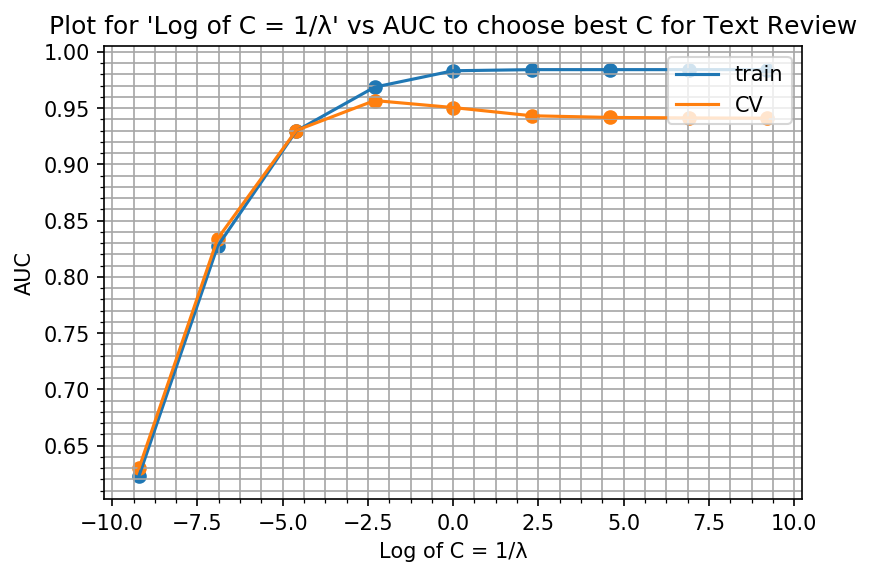

In [7]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_BOW_log, auc_train_bow_txt)
plt.scatter(C_LR_BOW_log, auc_train_bow_txt)
plt.plot(C_LR_BOW_log, auc_cv_bow_txt)
plt.scatter(C_LR_BOW_log, auc_cv_bow_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

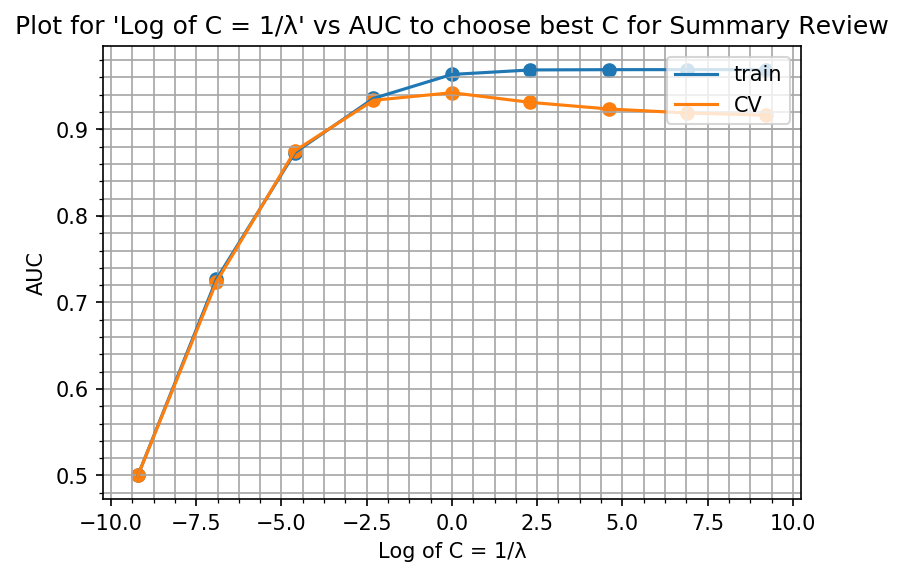

In [8]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_BOW_log, l1_auc_train_bow_summary)
plt.scatter(C_LR_BOW_log, l1_auc_train_bow_summary)
plt.plot(C_LR_BOW_log, l1_auc_cv_bow_summary)
plt.scatter(C_LR_BOW_log, l1_auc_cv_bow_summary)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Summary Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [9]:
import numpy as np
lis = np.arange (.01, 1, .05)
print (lis)

[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66
 0.71 0.76 0.81 0.86 0.91 0.96]


In [10]:
from sklearn.linear_model import LogisticRegression
auc_cv_bow_txt = []
auc_train_bow_txt=[]


for C in (lis):
    LR_BOW_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    LR_BOW_txt.fit(bow_X_train_txt, y_train)
    proba_pred_train_BOW_txt=(LR_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
    proba_pred_cv_BOW_txt=(LR_BOW_txt.predict_proba(bow_X_CV_txt)[:,1])
    auc_train_bow_txt.append(roc_auc_score(y_train,proba_pred_train_BOW_txt))
    auc_cv_bow_txt.append(roc_auc_score(y_CV,proba_pred_cv_BOW_txt))
    

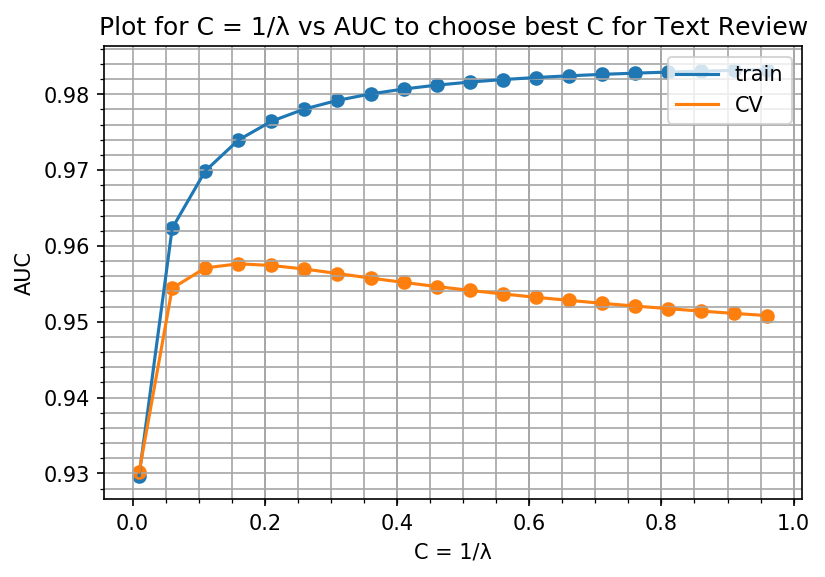

In [11]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis, auc_train_bow_txt)
plt.scatter(lis, auc_train_bow_txt)
plt.plot(lis, auc_cv_bow_txt)
plt.scatter(lis, auc_cv_bow_txt)
plt.xlabel('C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for C = 1/λ vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### So the best C is 0.16 for Text Review

In [12]:
import numpy as np
lis2 = np.arange (.1, 1, .05)
print (lis2)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


In [13]:
auc_cv_bow_summary = []
auc_train_bow_summary=[]

for C in tqdm(lis2):
    LR_BOW_sum = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    LR_BOW_sum.fit(bow_X_train_sum, y_summary_train)
    proba_pred_train_BOW_sum=(LR_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
    proba_pred_cv_BOW_sum=(LR_BOW_sum.predict_proba(bow_X_CV_sum)[:,1])
    auc_train_bow_summary.append(roc_auc_score(y_summary_train,proba_pred_train_BOW_sum))
    auc_cv_bow_summary.append(roc_auc_score(y_summary_CV,proba_pred_cv_BOW_sum))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.18it/s]


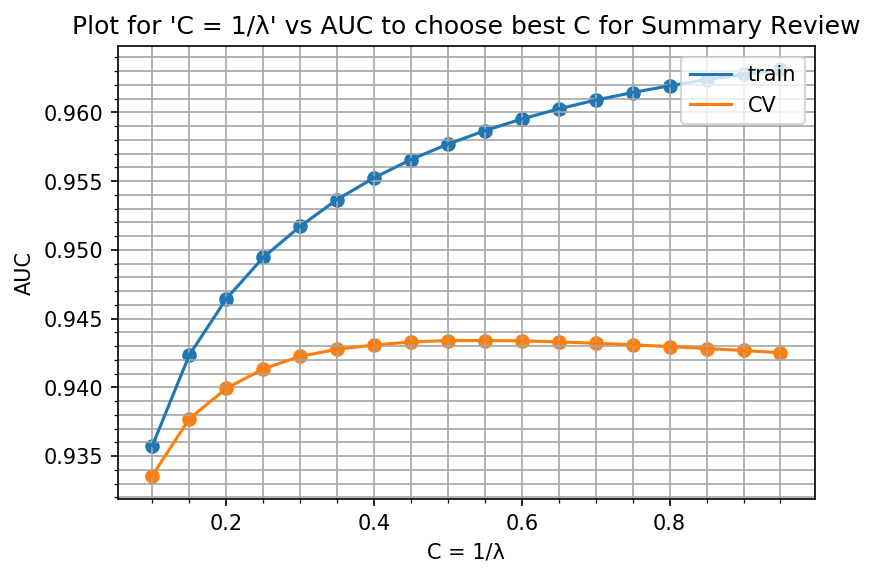

In [14]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis2, auc_train_bow_summary)
plt.scatter(lis2, auc_train_bow_summary)
plt.plot(lis2, auc_cv_bow_summary)
plt.scatter(lis2, auc_cv_bow_summary)
plt.xlabel('C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'C = 1/λ' vs AUC to choose best C for Summary Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### Best C for Summary Review is .6

In [15]:
bestC_L1_BOW_txt = LogisticRegression(penalty='l1',C=.16, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_txt.fit(bow_X_train_txt, y_train)
l1_proba_pred_train_BOW_txt=(bestC_L1_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
l1_proba_pred_test_BOW_txt=(bestC_L1_BOW_txt.predict_proba(bow_X_test_txt)[:,1])

l1_auc_test_BOW  = (roc_auc_score(y_test,l1_proba_pred_test_BOW_txt))
l1_auc_train_BOW  = (roc_auc_score(y_train,l1_proba_pred_train_BOW_txt))


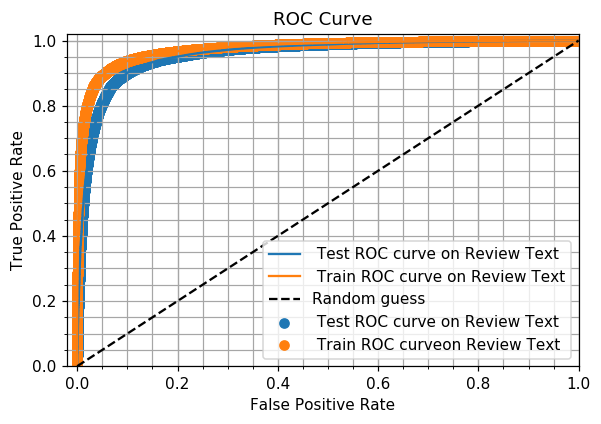

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, thresholds = roc_curve(y_test, l1_proba_pred_test_BOW_txt)
fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, thresholds = roc_curve(y_train, l1_proba_pred_train_BOW_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [17]:
bestC_L1_BOW_txt = LogisticRegression(penalty='l1',C=.16, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_txt.fit(bow_X_train_txt, y_train)
l1_pred_train_BOW_txt=(bestC_L1_BOW_txt.predict(bow_X_train_txt))
l1_pred_test_BOW_txt=(bestC_L1_BOW_txt.predict(bow_X_test_txt))

In [18]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, l1_pred_test_BOW_txt))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l1_pred_train_BOW_txt))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.66      0.90      0.76     21261
          1       0.98      0.90      0.94     99648

avg / total       0.92      0.90      0.91    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.65      0.93      0.76     22681
          1       0.99      0.92      0.95    141791

avg / total       0.94      0.92      0.93    164472



IN NOT NORMALIZED FORMAT BELOW


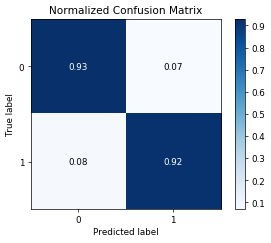

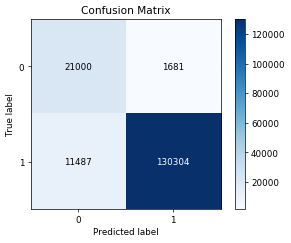

In [19]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train,l1_pred_train_BOW_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train,l1_pred_train_BOW_txt)

IN NOT NORMALIZED FORMAT BELOW


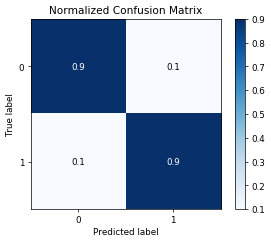

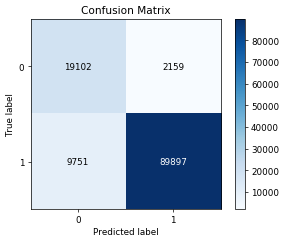

In [20]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l1_pred_test_BOW_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l1_pred_test_BOW_txt)

### Lets perform the same over Summary Text

In [21]:
bestC_L1_BOW_sum = LogisticRegression(penalty='l1',C=.6, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_sum.fit(bow_X_train_sum, y_summary_train)
L1_proba_pred_train_BOW_sum=(bestC_L1_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
L1_proba_pred_test_BOW_sum=(bestC_L1_BOW_sum.predict_proba(bow_X_test_sum)[:,1])

In [22]:
l1_auc_test_BOW  = (roc_auc_score(y_test,L1_proba_pred_test_BOW_sum))
l1_auc_train_BOW  = (roc_auc_score(y_train,L1_proba_pred_train_BOW_sum))

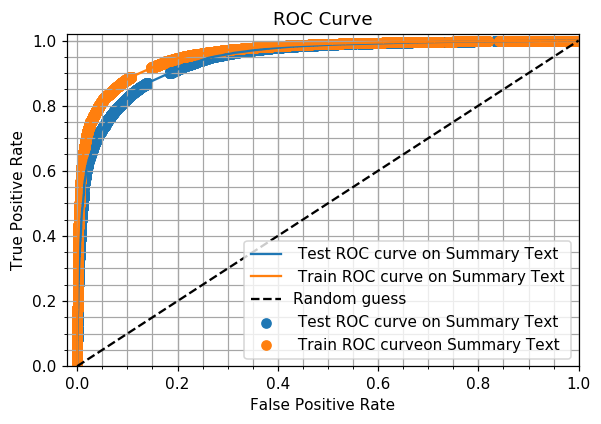

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_l1_sum, tpr_test_bow_l1_sum, thresholds = roc_curve(y_summary_test, L1_proba_pred_test_BOW_sum)
fpr_train_bow_l1_sum, tpr_train_bow_l1_sum, thresholds = roc_curve(y_summary_train, L1_proba_pred_train_BOW_sum)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_l1_sum, tpr_test_bow_l1_sum, label=' Test ROC curve on Summary Text')
plt.scatter(fpr_test_bow_l1_sum, tpr_test_bow_l1_sum, label=' Test ROC curve on Summary Text')
plt.plot(fpr_train_bow_l1_sum, tpr_train_bow_l1_sum, label=' Train ROC curve on Summary Text')
plt.scatter(fpr_train_bow_l1_sum, tpr_train_bow_l1_sum, label=' Train ROC curveon Summary Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [24]:
bestC_L1_BOW_sum = LogisticRegression(penalty='l1',C=.6, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_sum.fit(bow_X_train_sum, y_summary_train)
L1_pred_train_BOW_sum=(bestC_L1_BOW_sum.predict(bow_X_train_sum))
L1_pred_test_BOW_sum=(bestC_L1_BOW_sum.predict(bow_X_test_sum))

In [25]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_summary_test, L1_pred_test_BOW_sum))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_summary_train, L1_pred_train_BOW_sum))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.56      0.88      0.68     21261
          1       0.97      0.85      0.91     99648

avg / total       0.90      0.86      0.87    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.53      0.91      0.67     22681
          1       0.98      0.87      0.93    141791

avg / total       0.92      0.88      0.89    164472



IN NOT NORMALIZED FORMAT BELOW


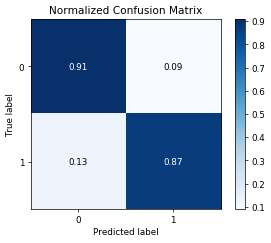

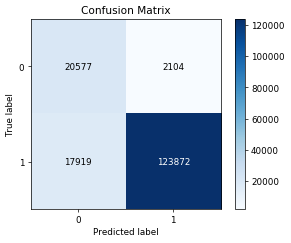

In [26]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_train,L1_pred_train_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_train,L1_pred_train_BOW_sum)

IN NOT NORMALIZED FORMAT BELOW


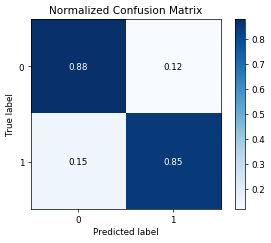

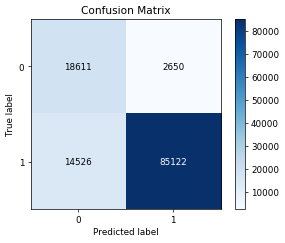

In [27]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_test, L1_pred_test_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_test, L1_pred_test_BOW_sum)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [28]:
import numpy as np
bestC_L1_BOW_sum = LogisticRegression(penalty='l1',C=.55, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_sum.fit(bow_X_summary_train, y_summary_train)
coef_ =bestC_L1_BOW_sum.coef_
bow_features_name_l1_sum = bow_vect.get_feature_names()
sparsity_wght_df = pd.DataFrame(coef_, columns = bow_features_name_l1_sum)
sparsity_wght_df_trans = sparsity_wght_df.T
sparsity_wght_df_trans.columns = ["Weight"]
print (sparsity_wght_df_trans)


                 Weight
10            -0.182671
10 star        2.205732
100           -0.408930
100 calorie    1.080471
100 juice      0.000000
100 natural    0.000000
100 pure      -0.308794
100 whole      0.000000
11            -1.299526
12            -0.016507
12 ounce       0.000000
12 oz          0.000000
13             0.000000
130            0.000000
14            -0.165057
15            -0.228623
16             0.000000
16 ounce       0.000000
16 oz          0.000000
17             0.000000
18             0.000000
1866           0.000000
19             0.000000
1st           -0.180391
20            -0.997673
2008          -2.081325
2010           0.000000
2011          -1.596866
21            -0.200899
24             0.000000
...                 ...
yummy good     0.000000
yummy great    0.000000
yummy gummi    0.000000
yummy healthi  0.000000
yummy healthy  0.000000
yummy little   0.000000
yummy low      0.000000
yummy not      0.000000
yummy snack    0.000000
yummy stuff    0

In [29]:
#https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.count_nonzero.html
sparsity_wght_df_trans_non_zero = np.count_nonzero(sparsity_wght_df_trans)
print (sparsity_wght_df_trans_non_zero)

3799


### <font color='green'>So we see out of 9000 only 3799 are nonzero weights vectors. That means only 3799 are relevant features to consider and rest (i.e. 9000-3799=5201) words vectors/features could be discarded as per L1 regularization </font> 

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [30]:
from sklearn.linear_model import LogisticRegression
l2_auc_cv_bow_txt = []
l2_auc_train_bow_txt=[]


for C in (C_LR_BOW):
    L2_BOW_txt = LogisticRegression(penalty='l2',C=C, fit_intercept=True,intercept_scaling=1,class_weight='balanced')
    L2_BOW_txt.fit(bow_X_train_txt, y_train)
    l2_proba_pred_train_BOW_txt=(L2_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
    l2_proba_pred_cv_BOW_txt=(L2_BOW_txt.predict_proba(bow_X_CV_txt)[:,1])
    l2_auc_train_bow_txt.append(roc_auc_score(y_train,l2_proba_pred_train_BOW_txt))
    l2_auc_cv_bow_txt.append(roc_auc_score(y_CV,l2_proba_pred_cv_BOW_txt))
    


In [31]:
print (C_LR_BOW)
print (C_LR_BOW_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


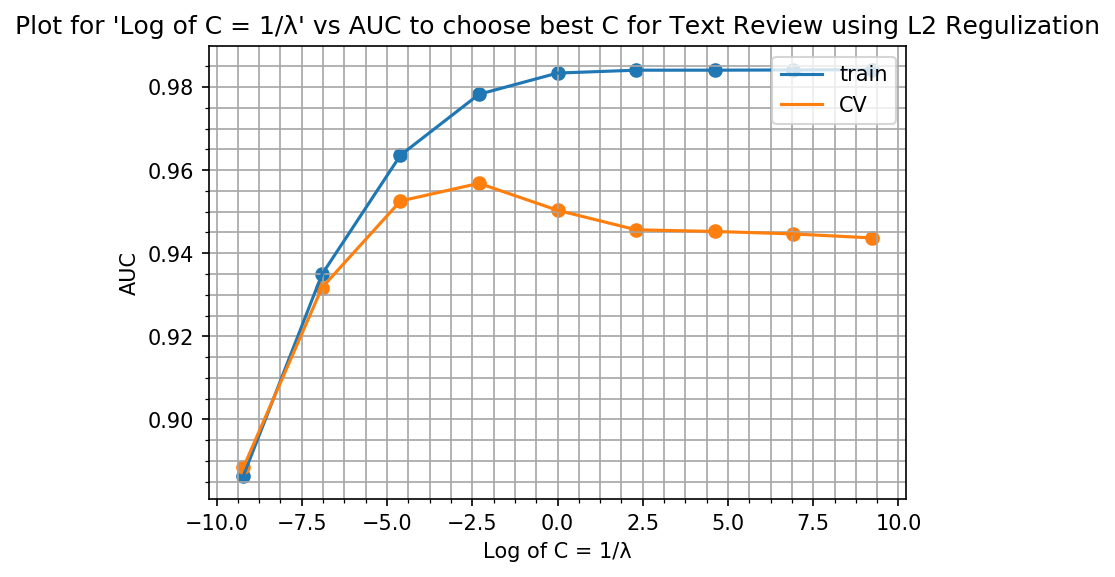

In [32]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_BOW_log, l2_auc_train_bow_txt)
plt.scatter(C_LR_BOW_log, l2_auc_train_bow_txt)
plt.plot(C_LR_BOW_log, l2_auc_cv_bow_txt)
plt.scatter(C_LR_BOW_log, l2_auc_cv_bow_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review using L2 Regulization")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [33]:
import numpy as np
list_l2 = np.arange (.01, 1, .05)
print (list_l2)

[0.01 0.06 0.11 0.16 0.21 0.26 0.31 0.36 0.41 0.46 0.51 0.56 0.61 0.66
 0.71 0.76 0.81 0.86 0.91 0.96]


In [34]:
from sklearn.linear_model import LogisticRegression
l2_auc_cv_bow_txt = []
l2_auc_train_bow_txt=[]


for C in (list_l2):
    L2_BOW_txt = LogisticRegression(penalty='l2',C=C, fit_intercept=True,intercept_scaling=1, verbose =1,class_weight='balanced')
    L2_BOW_txt.fit(bow_X_train_txt, y_train)
    l2_proba_pred_train_BOW_txt=(L2_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
    l2_proba_pred_cv_BOW_txt=(L2_BOW_txt.predict_proba(bow_X_CV_txt)[:,1])
    l2_auc_train_bow_txt.append(roc_auc_score(y_train,l2_proba_pred_train_BOW_txt))
    l2_auc_cv_bow_txt.append(roc_auc_score(y_CV,l2_proba_pred_cv_BOW_txt))
    


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

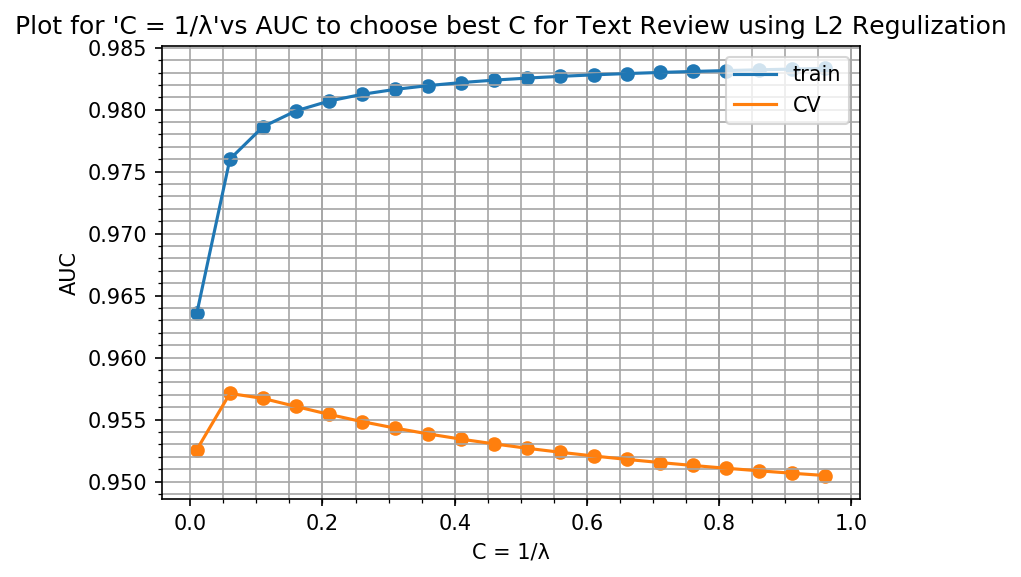

In [35]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(list_l2, l2_auc_train_bow_txt)
plt.scatter(list_l2, l2_auc_train_bow_txt)
plt.plot(list_l2, l2_auc_cv_bow_txt)
plt.scatter(list_l2, l2_auc_cv_bow_txt)
plt.xlabel('C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'C = 1/λ'vs AUC to choose best C for Text Review using L2 Regulization")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### Best C is .06 for Text Review using L2 Regulization

In [36]:
bestC_l2_proba_pred_train_BOW_txt = []
bestC_l2_proba_pred_test_BOW_txt = []

bestC_L2_BOW_txt = LogisticRegression(penalty='l2',C=.06, fit_intercept=True,intercept_scaling=1, verbose =1,class_weight='balanced')
bestC_L2_BOW_txt.fit(bow_X_train_txt, y_train)
bestC_l2_proba_pred_train_BOW_txt=(bestC_L2_BOW_txt.predict_proba(bow_X_train_txt)[:,1])
bestC_l2_proba_pred_test_BOW_txt=(bestC_L2_BOW_txt.predict_proba(bow_X_test_txt)[:,1])

[LibLinear]

In [37]:
l2_auc_test_BOW  = (roc_auc_score(y_test,bestC_l2_proba_pred_test_BOW_txt))
l2_auc_train_BOW  = (roc_auc_score(y_train,bestC_l2_proba_pred_train_BOW_txt))

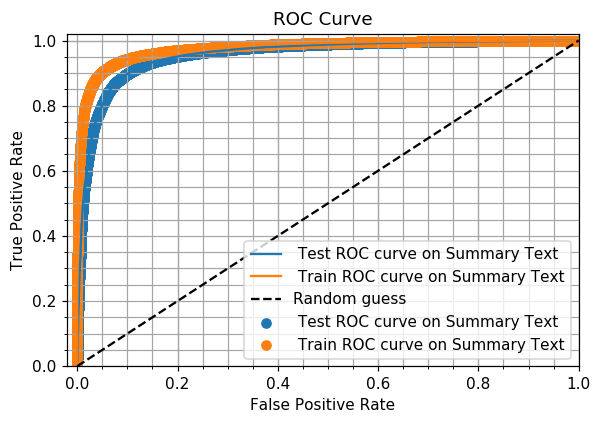

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_l2_txt, tpr_test_bow_l2_txt, thresholds = roc_curve(y_test, bestC_l2_proba_pred_test_BOW_txt)
fpr_train_bow_l2_txt, tpr_train_bow_l2_txt, thresholds = roc_curve(y_train, bestC_l2_proba_pred_train_BOW_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_l2_txt, tpr_test_bow_l2_txt, label=' Test ROC curve on Summary Text')
plt.scatter(fpr_test_bow_l2_txt, tpr_test_bow_l2_txt, label=' Test ROC curve on Summary Text')
plt.plot(fpr_train_bow_l2_txt, tpr_train_bow_l2_txt, label=' Train ROC curve on Summary Text')
plt.scatter(fpr_train_bow_l2_txt, tpr_train_bow_l2_txt, label=' Train ROC curve on Summary Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [39]:
bestC_L2_BOW_txt = LogisticRegression(penalty='l2',C=.06, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_BOW_txt.fit(bow_X_train_txt, y_train)
l2_pred_train_BOW_txt=(bestC_L2_BOW_txt.predict(bow_X_train_txt))
l2_pred_test_BOW_txt=(bestC_L1_BOW_txt.predict(bow_X_test_txt))

In [40]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, l2_pred_test_BOW_txt))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l2_pred_train_BOW_txt))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.66      0.90      0.76     21261
          1       0.98      0.90      0.94     99648

avg / total       0.92      0.90      0.91    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.65      0.93      0.77     22681
          1       0.99      0.92      0.95    141791

avg / total       0.94      0.92      0.93    164472



IN NOT NORMALIZED FORMAT BELOW


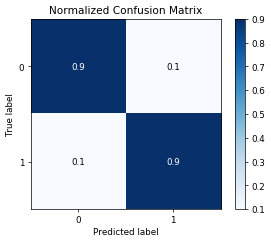

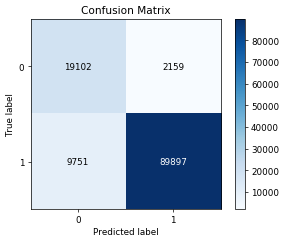

In [41]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l2_pred_test_BOW_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l2_pred_test_BOW_txt)

IN NOT NORMALIZED FORMAT BELOW


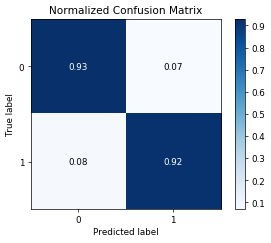

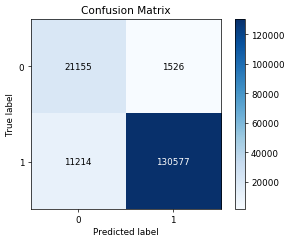

In [42]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l2_pred_train_BOW_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l2_pred_train_BOW_txt)

In [43]:
l2_auc_cv_bow_summary = []
L2_auc_train_bow_summary=[]

for C in tqdm(C_LR_BOW):
    L2_BOW_sum = LogisticRegression(penalty='l2',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L2_BOW_sum.fit(bow_X_train_sum, y_summary_train)
    proba_pred_train_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
    proba_pred_cv_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_CV_sum)[:,1])
    L2_auc_train_bow_summary.append(roc_auc_score(y_summary_train,proba_pred_train_BOW_sum))
    l2_auc_cv_bow_summary.append(roc_auc_score(y_summary_CV,proba_pred_cv_BOW_sum))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:00<00:00, 13.93s/it]


In [44]:
print (C_LR_BOW)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


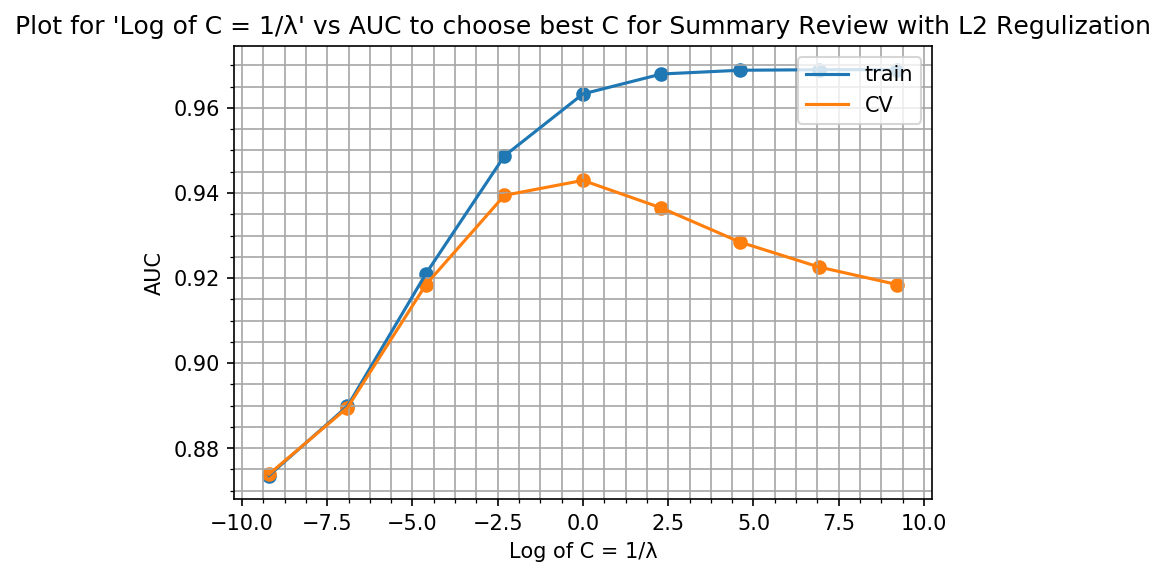

In [45]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_BOW_log, L2_auc_train_bow_summary)
plt.scatter(C_LR_BOW_log, L2_auc_train_bow_summary)
plt.plot(C_LR_BOW_log, l2_auc_cv_bow_summary)
plt.scatter(C_LR_BOW_log, l2_auc_cv_bow_summary)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Summary Review with L2 Regulization")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [46]:
import numpy as np
list_l2_sum = np.arange (.1, 10, .2)
print (list_l2_sum)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5
 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3 5.5 5.7 5.9 6.1 6.3 6.5 6.7 6.9 7.1
 7.3 7.5 7.7 7.9 8.1 8.3 8.5 8.7 8.9 9.1 9.3 9.5 9.7 9.9]


In [47]:
l2_auc_cv_bow_summary = []
L2_auc_train_bow_summary=[]

for C in (list_l2_sum):
    L2_BOW_sum = LogisticRegression(penalty='l2',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L2_BOW_sum.fit(bow_X_train_sum, y_summary_train)
    proba_pred_train_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
    proba_pred_cv_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_CV_sum)[:,1])
    L2_auc_train_bow_summary.append(roc_auc_score(y_summary_train,proba_pred_train_BOW_sum))
    l2_auc_cv_bow_summary.append(roc_auc_score(y_summary_CV,proba_pred_cv_BOW_sum))
    

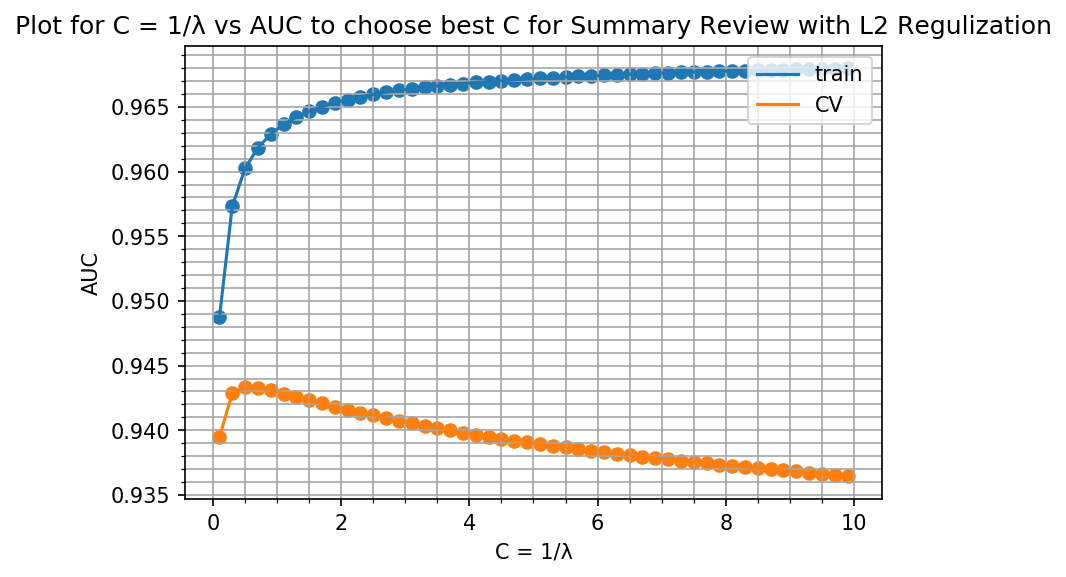

In [48]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(list_l2_sum, L2_auc_train_bow_summary)
plt.scatter(list_l2_sum, L2_auc_train_bow_summary)
plt.plot(list_l2_sum, l2_auc_cv_bow_summary)
plt.scatter(list_l2_sum, l2_auc_cv_bow_summary)
plt.xlabel('C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for C = 1/λ vs AUC to choose best C for Summary Review with L2 Regulization")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

#### So the best Value of C for summary text using L2 Regulization is .5

In [49]:
L2_BOW_sum = LogisticRegression(penalty='l2',C=.5, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
L2_BOW_sum.fit(bow_X_train_sum, y_summary_train)
bestC_proba_pred_train_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_train_sum)[:,1])
bestC_proba_pred_test_BOW_sum=(L2_BOW_sum.predict_proba(bow_X_test_sum)[:,1])

In [50]:
l2_auc_test_BOW_sum  = (roc_auc_score(y_summary_test,bestC_proba_pred_test_BOW_sum))
l2_auc_train_BOW_sum  = (roc_auc_score(y_summary_train,bestC_proba_pred_train_BOW_sum))

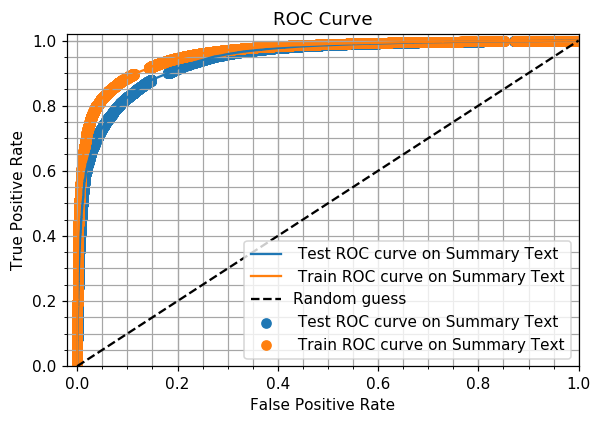

In [51]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_l2_sum, tpr_test_bow_l2_sum, thresholds = roc_curve(y_summary_test, bestC_proba_pred_test_BOW_sum)
fpr_train_bow_l2_sum, tpr_train_bow_l2_sum, thresholds = roc_curve(y_summary_train, bestC_proba_pred_train_BOW_sum)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_l2_sum, tpr_test_bow_l2_sum, label=' Test ROC curve on Summary Text')
plt.scatter(fpr_test_bow_l2_sum, tpr_test_bow_l2_sum, label=' Test ROC curve on Summary Text')
plt.plot(fpr_train_bow_l2_sum, tpr_train_bow_l2_sum, label=' Train ROC curve on Summary Text')
plt.scatter(fpr_train_bow_l2_sum, tpr_train_bow_l2_sum, label=' Train ROC curve on Summary Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [52]:
bestC_L2_BOW_sum = LogisticRegression(penalty='l1',C=.5, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_BOW_sum.fit(bow_X_train_sum, y_summary_train)
L2_pred_train_BOW_sum=(bestC_L2_BOW_sum.predict(bow_X_train_sum))
L2_pred_test_BOW_sum=(bestC_L2_BOW_sum.predict(bow_X_test_sum))

IN NOT NORMALIZED FORMAT BELOW


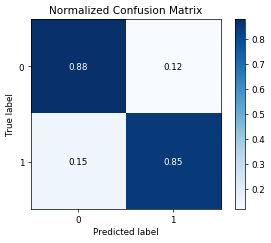

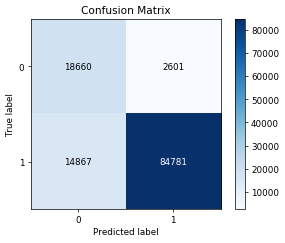

In [53]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_test, L2_pred_test_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_test, L2_pred_test_BOW_sum)

IN NOT NORMALIZED FORMAT BELOW


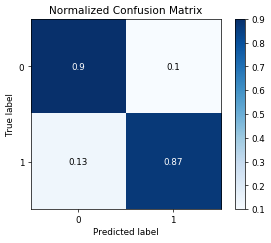

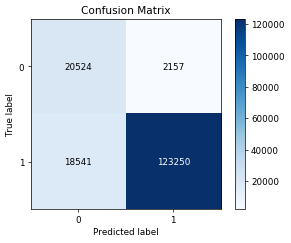

In [54]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_train, L2_pred_train_BOW_sum,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_train, L2_pred_train_BOW_sum)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [55]:
bow_vect2 = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=4000)
bow_X_train_no_stop_4k = bow_vect2.fit_transform(X_no_stop_train)
bow_X_test_no_stop_4k = bow_vect2.transform(X_no_stop_test)
bow_X_CV_no_stop_4k = bow_vect2.transform(X_no_stop_CV)
##################################################
bow_X_summary_train_4k = bow_vect2.fit_transform(X_summary_train)
bow_X_summary_test_4k = bow_vect2.transform(X_summary_test)
bow_X_summary_CV_4k = bow_vect2.transform(X_summary_CV)
#########################################################
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

bow_X_train_txt_4k =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_train_no_stop_4k)
bow_X_test_txt_4k = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_test_no_stop_4k)
bow_X_CV_txt_4k = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_CV_no_stop_4k)
########################################
bow_X_train_sum_4k =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_train_4k)
bow_X_test_sum_4k = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_test_4k)
bow_X_CV_sum_4k = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_CV_4k)
print (bow_X_train_txt_4k.shape)
#########################################
#noise = np.random.normal(0,.03,[164472, 4000]).astype(np.float16)
#bow_X_train_no_stop_float16 = bow_X_train_no_stop.astype(np.float16)
#print (bow_X_train_no_stop_float16.shape)

(164472, 4000)


In [56]:
import numpy as np
from sklearn.linear_model import LogisticRegression

bestC_L2_BOW_txt_4k = LogisticRegression(penalty='l2',C=.06, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_BOW_txt_4k.fit(bow_X_train_txt_4k, y_train)
coef_l2 =bestC_L2_BOW_txt_4k.coef_
bow_features_name_l2_txt_4k = bow_vect2.get_feature_names()
l2_wght_df = pd.DataFrame(coef_l2, columns = bow_features_name_l2_txt_4k)
l2_wght_df_trans = l2_wght_df.T
l2_wght_df_trans.columns = ["Weight"]


In [57]:
#https://stackoverflow.com/questions/46093073/adding-gaussian-noise-to-a-dataset-of-floating-points-and-save-it-python

target_dims = bow_X_train_txt_4k.shape
noise = np.random.normal(scale=.03,size=[164472, 4000])
noisy_bow_X_train_txt = bow_X_train_txt_4k + noise

In [58]:
#######################################################
#Lets calculate the Weights with noisy training data 

bestC_L2_BOW_txt_4k_noisy = LogisticRegression(penalty='l2',C=.06, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_BOW_txt_4k_noisy.fit(noisy_bow_X_train_txt, y_train)
coef_noisy =bestC_L2_BOW_txt_4k_noisy.coef_
bow_features_name_l2_txt_4k_noisy = bow_vect2.get_feature_names()
l2_wght_df_noisy = pd.DataFrame(coef_noisy, columns = bow_features_name_l2_txt_4k_noisy)
l2_wght_df_trans_noisy = l2_wght_df_noisy.T
l2_wght_df_trans_noisy.columns = ["Weight"]

In [59]:
print (l2_wght_df_trans)
print (l2_wght_df_trans_noisy)

                        Weight
10                   -0.173259
10 star              -0.083588
100                  -0.090209
100 calorie          -0.010128
11                    0.059754
12                    0.163083
14                   -0.023536
15                    0.571035
16                   -0.079238
17                   -0.085166
18                   -0.076257
1st                  -0.212233
20                   -0.143034
24                    0.175945
25                   -0.134752
2nd                   0.427156
30                   -0.241678
35                   -0.057779
40                   -0.096686
45                   -0.062449
50                   -0.238180
70                    0.080523
able                  0.138256
absolute              0.051144
absolute best        -0.409328
absolutely            0.152942
absolutely best      -0.157167
absolutely delici     0.019550
absolutely delicious -0.042098
absolutely lov       -0.308636
...                        ...
yucky   

In [60]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.subtract.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
l2_wght_df_after_subtraction=l2_wght_df_trans.subtract(l2_wght_df_trans_noisy)
l2_wght_df_after_subtraction = l2_wght_df_after_subtraction.sort_values('Weight',ascending=True)
print (l2_wght_df_after_subtraction)


                  Weight
great variety  -0.479635
hyp            -0.394818
good health    -0.337734
boxes pack     -0.327244
homemade       -0.323224
watermelon     -0.297960
drinking       -0.296387
throw          -0.294883
good earth     -0.287281
formula        -0.271717
didnt          -0.270823
ev             -0.270501
miracle        -0.265171
complex        -0.262315
hazard         -0.259818
fan            -0.256949
lovely tea     -0.256929
dry            -0.253898
season         -0.250691
lentil         -0.245526
smells great   -0.245460
job            -0.244945
tasting green  -0.244550
tahini         -0.242901
noodl          -0.236692
simple         -0.236300
good source    -0.235911
fragrant       -0.235876
chipotle       -0.233437
nothing like   -0.233001
...                  ...
mini            0.307036
matcha          0.307323
ahmad           0.313447
good stuff      0.315987
almonds         0.320511
ill             0.320779
assorted        0.322816
issues          0.323769


In [61]:
bestC_L2_BOW_txt_4k_noisy = LogisticRegression(penalty='l2',C=.06, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_BOW_txt_4k_noisy.fit(noisy_bow_X_train_txt, y_train)
bestC_proba_pred_train_BOW_sum_noisy=(bestC_L2_BOW_txt_4k_noisy.predict_proba(noisy_bow_X_train_txt)[:,1])
bestC_proba_pred_test_BOW_sum_noisy=(bestC_L2_BOW_txt_4k_noisy.predict_proba(bow_X_test_sum_4k)[:,1])
###################################################################################################3
l2_auc_test_BOW_sum_noisy  = (roc_auc_score(y_summary_test,bestC_proba_pred_test_BOW_sum_noisy))
l2_auc_train_BOW_sum_noisy  = (roc_auc_score(y_summary_train,bestC_proba_pred_train_BOW_sum_noisy))
print ("AUC for Test Data for Summary Text")
print (l2_auc_test_BOW_sum)
print ("AUC for Train Data for Summary Text")
print (l2_auc_train_BOW_sum)
print ("AUC for Test Data for Summary Text after introducing Noise")
print (l2_auc_test_BOW_sum_noisy)
print ("AUC for Train Data for Summary Text after introducing Noise")
print (l2_auc_train_BOW_sum_noisy)


AUC for Test Data for Summary Text
0.9424611174771534
AUC for Train Data for Summary Text
0.9602455659988494
AUC for Test Data for Summary Text after introducing Noise
0.49928546116495914
AUC for Train Data for Summary Text after introducing Noise
0.959400814948332


IN NOT NORMALIZED FORMAT BELOW


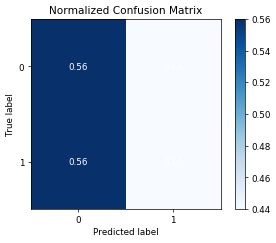

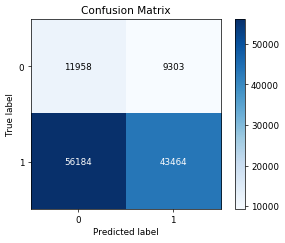

In [62]:
##############################################################################################
bestC_pred_train_BOW_sum_noisy=(bestC_L2_BOW_txt_4k_noisy.predict(noisy_bow_X_train_txt))
bestC_pred_test_BOW_sum_noisy=(bestC_L2_BOW_txt_4k_noisy.predict(bow_X_test_sum_4k))
###############################################################################################
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_test, bestC_pred_test_BOW_sum_noisy,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_test, bestC_pred_test_BOW_sum_noisy)

IN NOT NORMALIZED FORMAT BELOW


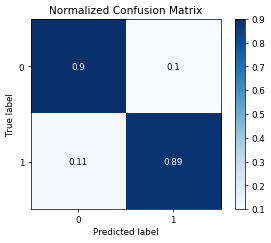

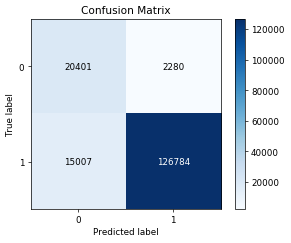

In [63]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_summary_train, bestC_pred_train_BOW_sum_noisy,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_summary_train, bestC_pred_train_BOW_sum_noisy)

### <font color='red'> Thus we can see the features are very collinear after introducing small noise we can see the TPR and FPR wasnt that much affected for training dataset as compared with TPR and FPR after introduction of noise </font>

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [64]:
import numpy as np
bestC_L1_BOW_sum = LogisticRegression(penalty='l1',C=.55, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_BOW_sum.fit(bow_X_summary_train, y_summary_train)
coef_ =bestC_L1_BOW_sum.coef_
bow_features_name_l1_sum = bow_vect.get_feature_names()
sparsity_wght_df = pd.DataFrame(coef_, columns = bow_features_name_l1_sum)
sparsity_wght_df_trans = sparsity_wght_df.T
sparsity_wght_df_trans.columns = ["Weight"]
#print (sparsity_wght_df_trans)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.abs.html
sparsity_wght_df_trans_abs = sparsity_wght_df_trans.abs()
#print (sparsity_wght_df_trans_abs)
print (sparsity_wght_df_trans.sort_values('Weight',ascending=False).head(10))

                   Weight
not bitter       8.213487
not bad          7.881789
wont disappoint  5.992895
whats not        5.968882
heaven           5.448181
not salti        5.403594
not bitt         5.366013
no problem       5.019613
fantast          4.987004
go wrong         4.893911


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [65]:
print (sparsity_wght_df_trans.sort_values('Weight',ascending=True).head(10))

                  Weight
yuck           -6.202488
ruined         -5.496440
mediocre       -5.419876
yummy yummi    -5.402339
worst          -5.233702
least favorite -5.183203
terribl        -4.955913
horribl        -4.943413
aw             -4.730430
taste better   -4.695597


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,5))
tfidf_X_train = tf_idf_vect.fit_transform(X_no_stop_train)
tfidf_X_test = tf_idf_vect.transform(X_no_stop_test)
tfidf_X_CV = tf_idf_vect.transform(X_no_stop_CV)

tfidf_X_train =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_train)
tfidf_X_test = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_test)
tfidf_X_CV = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_CV)

# creating odd list of C(i.e. 1/lambda) for BOW Logistic Regression
def tothepower(y):
    return (10**y)
C_LR_tfidf = list(map(tothepower, list(range(-4, 5))))
print (C_LR_tfidf)
C_LR_tfidf_log = [math.log(x) for x in C_LR_tfidf]
print (C_LR_tfidf_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:46<00:00, 51.99s/it]


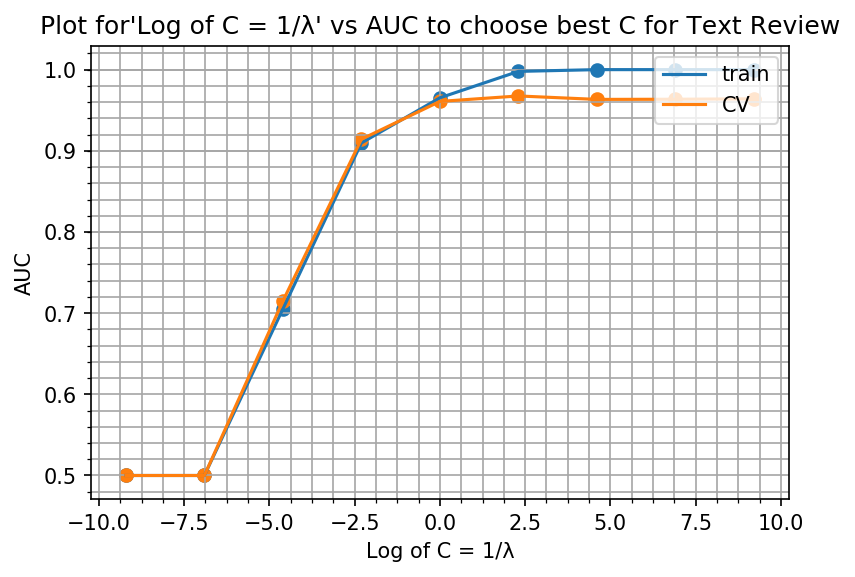

In [67]:
from sklearn.linear_model import LogisticRegression
auc_cv_tfidf_txt = []
auc_train_tfidf_txt=[]


for C in tqdm(C_LR_tfidf):
    L1_tfidf_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L1_tfidf_txt.fit(tfidf_X_train, y_train)
    proba_pred_train_tfidf_txt=(L1_tfidf_txt.predict_proba(tfidf_X_train)[:,1])
    proba_pred_cv_tfidf_txt=(L1_tfidf_txt.predict_proba(tfidf_X_CV)[:,1])
    auc_train_tfidf_txt.append(roc_auc_score(y_train,proba_pred_train_tfidf_txt))
    auc_cv_tfidf_txt.append(roc_auc_score(y_CV,proba_pred_cv_tfidf_txt))
    
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_tfidf_log, auc_train_tfidf_txt)
plt.scatter(C_LR_tfidf_log, auc_train_tfidf_txt)
plt.plot(C_LR_tfidf_log, auc_cv_tfidf_txt)
plt.scatter(C_LR_tfidf_log, auc_cv_tfidf_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for'Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [68]:
import numpy as np
lis_tfidf = np.arange (1, 15, 1)
print (lis_tfidf)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [69]:
l1_auc_train_tfidf_txt = []
l1_auc_cv_tfidf_txt = []
for C in tqdm(lis_tfidf):
    L1_tfidf_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L1_tfidf_txt.fit(tfidf_X_train, y_train)
    proba_pred_train_tfidf_txt=(L1_tfidf_txt.predict_proba(tfidf_X_train)[:,1])
    proba_pred_cv_tfidf_txt=(L1_tfidf_txt.predict_proba(tfidf_X_CV)[:,1])
    l1_auc_train_tfidf_txt.append(roc_auc_score(y_train,proba_pred_train_tfidf_txt))
    l1_auc_cv_tfidf_txt.append(roc_auc_score(y_CV,proba_pred_cv_tfidf_txt))
   

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [09:31<00:00, 62.26s/it]


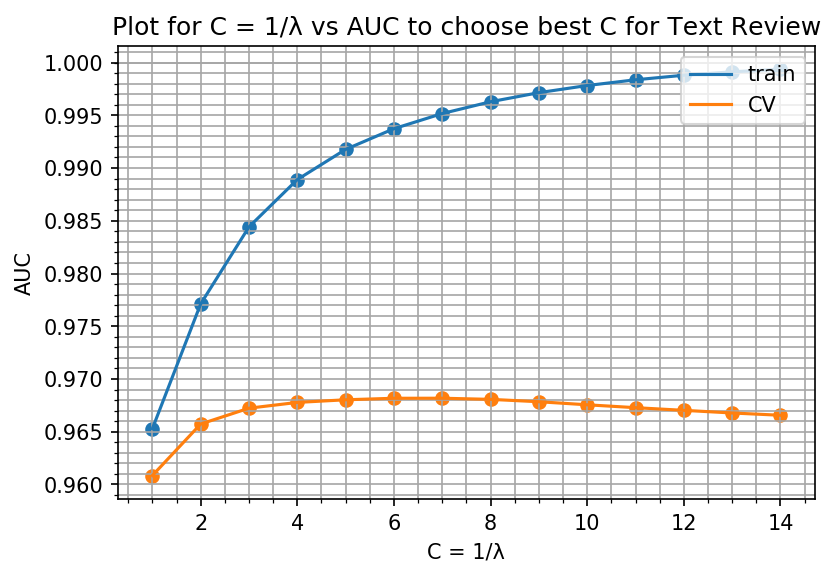

In [70]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_tfidf, l1_auc_train_tfidf_txt)
plt.scatter(lis_tfidf, l1_auc_train_tfidf_txt)
plt.plot(lis_tfidf, l1_auc_cv_tfidf_txt)
plt.scatter(lis_tfidf, l1_auc_cv_tfidf_txt)
plt.xlabel('C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for C = 1/λ vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### Best C = 6 when using TFIDF with L1 regulization

In [71]:
bestC_L1_tfidf_txt = LogisticRegression(penalty='l1',C=6, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_tfidf_txt.fit(tfidf_X_train, y_train)
l1_proba_pred_train_tfidf_txt=(bestC_L1_tfidf_txt.predict_proba(tfidf_X_train)[:,1])
l1_proba_pred_test_tfidf_txt=(bestC_L1_tfidf_txt.predict_proba(tfidf_X_test)[:,1])
l1_auc_test_tfidf = (roc_auc_score(y_test,l1_proba_pred_test_tfidf_txt))
l1_auc_train_tfidf  = (roc_auc_score(y_train,l1_proba_pred_train_tfidf_txt))


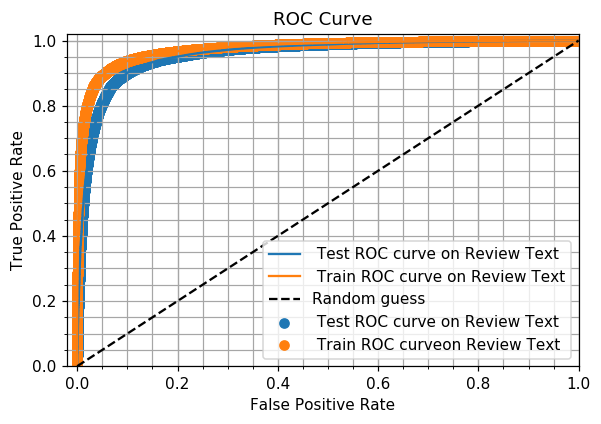

In [72]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, thresholds = roc_curve(y_test, l1_proba_pred_test_BOW_txt)
fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, thresholds = roc_curve(y_train, l1_proba_pred_train_BOW_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_l1_txt, tpr_test_bow_l1_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_l1_txt, tpr_train_bow_l1_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [73]:
bestC_L1_tfidf_txt = LogisticRegression(penalty='l1',C=6, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_tfidf_txt.fit(tfidf_X_train, y_train)
l1_pred_train_tfidf_txt=(bestC_L1_tfidf_txt.predict(tfidf_X_train))
l1_pred_test_tfidf_txt=(bestC_L1_tfidf_txt.predict(tfidf_X_test))

In [74]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, l1_pred_test_tfidf_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l1_pred_train_tfidf_txt))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.71      0.89      0.79     21261
          1       0.97      0.92      0.95     99648

avg / total       0.93      0.92      0.92    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.78      1.00      0.87     22681
          1       1.00      0.95      0.98    141791

avg / total       0.97      0.96      0.96    164472



IN NOT NORMALIZED FORMAT BELOW


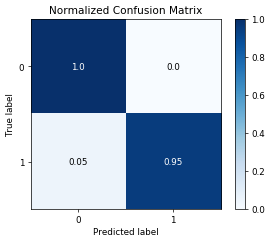

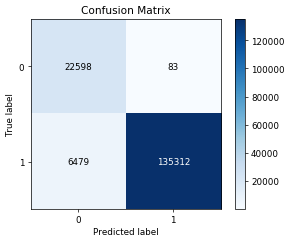

In [75]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l1_pred_train_tfidf_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l1_pred_train_tfidf_txt)

IN NOT NORMALIZED FORMAT BELOW


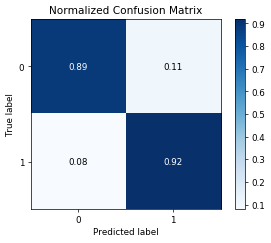

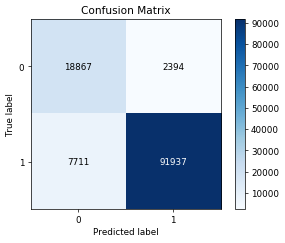

In [76]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l1_pred_test_tfidf_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l1_pred_test_tfidf_txt)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [77]:
from sklearn.linear_model import LogisticRegression
l2_auc_cv_tfidf_txt = []
l2_auc_train_tfidf_txt=[]


for C in (C_LR_tfidf):
    L2_tfidf_txt = LogisticRegression(penalty='l2',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L2_tfidf_txt.fit(tfidf_X_train, y_train)
    l2_proba_pred_train_tfidf_txt=(L2_tfidf_txt.predict_proba(tfidf_X_train)[:,1])
    l2_proba_pred_cv_tfidf_txt=(L2_tfidf_txt.predict_proba(tfidf_X_CV)[:,1])
    l2_auc_train_tfidf_txt.append(roc_auc_score(y_train,l2_proba_pred_train_tfidf_txt))
    l2_auc_cv_tfidf_txt.append(roc_auc_score(y_CV,l2_proba_pred_cv_tfidf_txt))
    


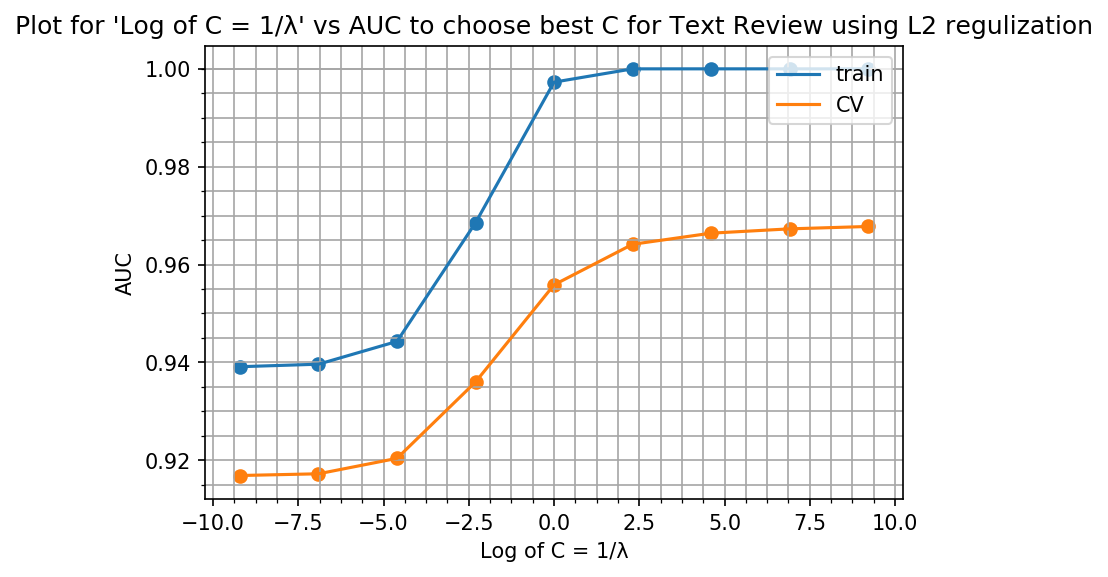

In [78]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_tfidf_log, l2_auc_train_tfidf_txt)
plt.scatter(C_LR_tfidf_log, l2_auc_train_tfidf_txt)
plt.plot(C_LR_tfidf_log, l2_auc_cv_tfidf_txt)
plt.scatter(C_LR_tfidf_log, l2_auc_cv_tfidf_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review using L2 regulization")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [79]:
bestC_L2_tfidf_txt = LogisticRegression(penalty='l2',C=10000, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_tfidf_txt.fit(tfidf_X_train, y_train)
l2_proba_pred_train_tfidf_txt=(bestC_L2_tfidf_txt.predict_proba(tfidf_X_train)[:,1])
l2_proba_pred_test_tfidf_txt=(bestC_L2_tfidf_txt.predict_proba(tfidf_X_test)[:,1])
l2_auc_test_tfidf = (roc_auc_score(y_test,l2_proba_pred_test_tfidf_txt))
l2_auc_train_tfidf  = (roc_auc_score(y_train,l2_proba_pred_train_tfidf_txt))


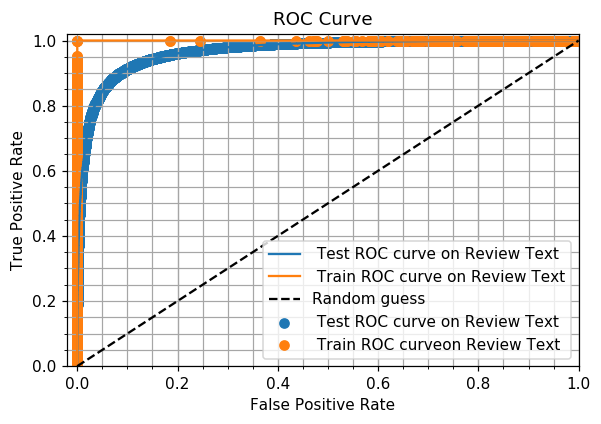

In [80]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_l2_txt, tpr_test_tfidf_l2_txt, thresholds = roc_curve(y_test, l2_proba_pred_test_tfidf_txt)
fpr_train_tfidf_l2_txt, tpr_train_tfidf_l2_txt, thresholds = roc_curve(y_train, l2_proba_pred_train_tfidf_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_l2_txt, tpr_test_tfidf_l2_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_l2_txt, tpr_test_tfidf_l2_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_l2_txt, tpr_train_tfidf_l2_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_l2_txt, tpr_train_tfidf_l2_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [81]:
bestC_L2_tfidf_txt = LogisticRegression(penalty='l2',C=10000, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_tfidf_txt.fit(tfidf_X_train, y_train)
l2_pred_train_tfidf_txt=(bestC_L2_tfidf_txt.predict(tfidf_X_train))
l2_pred_test_tfidf_txt=(bestC_L2_tfidf_txt.predict(tfidf_X_test))

In [82]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, l2_pred_test_tfidf_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l2_pred_train_tfidf_txt))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.80      0.82      0.81     21261
          1       0.96      0.96      0.96     99648

avg / total       0.93      0.93      0.93    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     22681
          1       1.00      1.00      1.00    141791

avg / total       1.00      1.00      1.00    164472



IN NOT NORMALIZED FORMAT BELOW


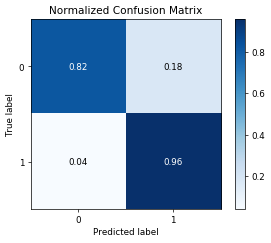

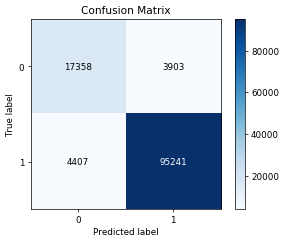

In [83]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l2_pred_test_tfidf_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l2_pred_test_tfidf_txt)

IN NOT NORMALIZED FORMAT BELOW


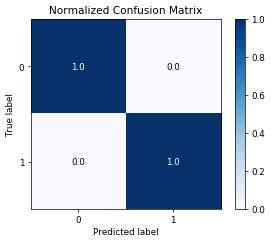

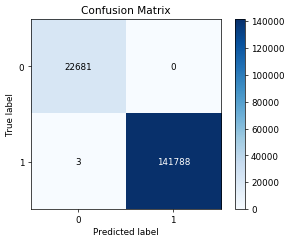

In [84]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l2_pred_train_tfidf_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l2_pred_train_tfidf_txt)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [85]:
import numpy as np
bestC_L2_tfidf_txt = LogisticRegression(penalty='l2',C=10000, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_tfidf_txt.fit(tfidf_X_train, y_train)
coef_l2_tfidf =bestC_L2_tfidf_txt.coef_
tfidf_features_name_l2_txt = tf_idf_vect.get_feature_names()
tfidf_l2_wght_df = pd.DataFrame(coef_l2_tfidf, columns = tfidf_features_name_l2_txt)
tfidf_l2_wght_df_trans = tfidf_l2_wght_df.T
tfidf_l2_wght_df_trans.columns = ["Weight"]
print (tfidf_l2_wght_df_trans.sort_values('Weight',ascending=False).head(10))

              Weight
great      96.471367
best       78.935136
delicious  71.667225
good       66.620629
perfect    61.326061
excellent  58.125593
loves      54.601299
wonderful  54.155668
love       53.792301
nice       46.991667


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [86]:
print (tfidf_l2_wght_df_trans.sort_values('Weight',ascending=True).head(10))

                  Weight
worst         -82.132212
disappointed  -82.044212
not           -71.219333
not worth     -66.471566
terrible      -64.783386
horrible      -61.847312
awful         -59.813053
not recommend -59.227251
not buy       -55.394758
unfortunately -54.677788


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [ ]:
lst_train=[]
lst_test=[]
lst_of_lst_train = []
lst_of_lst_test = []
lst_of_lst_CV =[]
lst_CV = []

for sentance in tqdm(X_no_stop_train):
    lst_train.append(sentance.strip())
for sentance in tqdm(lst_train):
    lst_of_lst_train.append(sentance.split())

for sent in tqdm(X_no_stop_test):
    lst_test.append(sent.strip())
for sent in tqdm(lst_test):
    lst_of_lst_test.append(sent.split())
    
for sent_CV in tqdm(X_no_stop_CV):
    lst_CV.append(sent_CV.strip())
for sent_CV in tqdm(lst_CV):
    lst_of_lst_CV.append(sent_CV.split())
    
w2v_model_self_taught_train=Word2Vec(lst_of_lst_train,min_count=1,size=50, workers=4)
w2v_words_train = list(w2v_model_self_taught_train.wv.vocab)


In [ ]:
sent_vectors_train_l1 = []
for sent1 in tqdm(lst_of_lst_train): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_train:
            vec1 = w2v_model_self_taught_train.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_train_l1.append(sent_vec1) 

In [ ]:
sent_vectors_test_l1 = []
for sent2 in tqdm(lst_of_lst_test): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_train:
            vec2 = w2v_model_self_taught_train.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_test_l1.append(sent_vec2)

In [ ]:
sent_vectors_CV_l1 = []
for sent3 in tqdm(lst_of_lst_CV): # for each review/sentence
    sent_vec3 = np.zeros(50)
    cnt_words3 = 0
    for word3 in sent3:
        if word3 in w2v_words_train:
            vec3 = w2v_model_self_taught_train.wv[word3]
            sent_vec3 += vec3
            cnt_words3 += 1
    if cnt_words3 != 0:
        sent_vec3 /= cnt_words3
    sent_vectors_CV_l1.append(sent_vec3)

In [91]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sent_vectors_train_l1_std =StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_train_l1)
sent_vectors_test_l1_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_test_l1)
sent_vectors_CV_l1_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_CV_l1)

In [92]:
def tothepower(y):
    return (10**y)
C_LR_avf_w2V = list(map(tothepower, list(range(-4, 5))))
print (C_LR_avf_w2V)
C_LR_avf_w2V_log = [math.log(x) for x in C_LR_avf_w2V]
print (C_LR_avf_w2V_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [ ]:
from sklearn.linear_model import LogisticRegression
auc_cv_avg_w2v_txt = []
auc_train_avg_w2v_txt=[]


for C in tqdm(C_LR_avf_w2V):
    L1_avg_w2v_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L1_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
    proba_pred_train_avg_w2v_txt=(L1_avg_w2v_txt.predict_proba(sent_vectors_train_l1_std)[:,1])
    proba_pred_cv_avg_w2v_txt=(L1_avg_w2v_txt.predict_proba(sent_vectors_CV_l1_std)[:,1])
    auc_train_avg_w2v_txt.append(roc_auc_score(y_train,proba_pred_train_avg_w2v_txt))
    auc_cv_avg_w2v_txt.append(roc_auc_score(y_CV,proba_pred_cv_avg_w2v_txt))


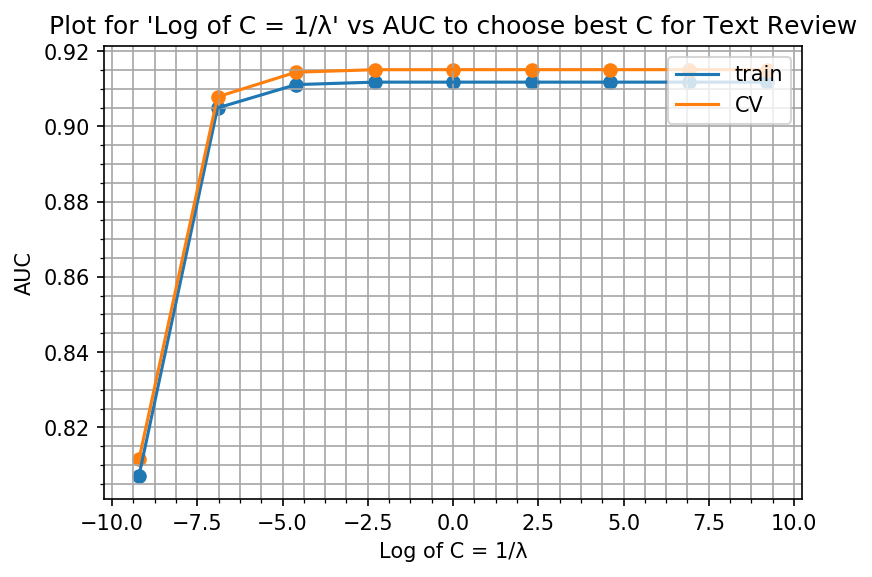

In [94]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_avf_w2V_log, auc_train_avg_w2v_txt)
plt.scatter(C_LR_avf_w2V_log, auc_train_avg_w2v_txt)
plt.plot(C_LR_avf_w2V_log, auc_cv_avg_w2v_txt)
plt.scatter(C_LR_avf_w2V_log, auc_cv_avg_w2v_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

#### The best value of C =1 for Avg-W2V against L1 regulization

In [95]:
bestCl1_auc_train_avg_w2v_txt = []
bestCl1_auc_test_avg_w2v_txt = []
bestC_L1_avg_w2v_txt = LogisticRegression(penalty='l1',C=1, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L1_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
bestC_proba_pred_train_avg_w2v_txt=(bestC_L1_avg_w2v_txt.predict_proba(sent_vectors_train_l1_std)[:,1])
bestC_proba_pred_test_avg_w2v_txt=(bestC_L1_avg_w2v_txt.predict_proba(sent_vectors_test_l1_std)[:,1])
bestCl1_auc_train_avg_w2v_txt.append(roc_auc_score(y_train,bestC_proba_pred_train_avg_w2v_txt))
bestCl1_auc_test_avg_w2v_txt.append(roc_auc_score(y_test,bestC_proba_pred_test_avg_w2v_txt))


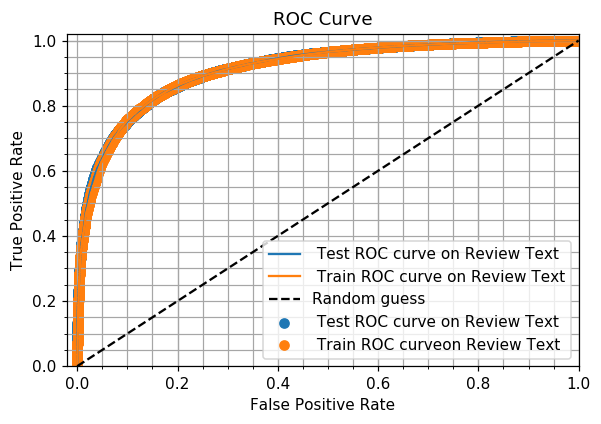

In [96]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avg_w2v_l1_txt, tpr_test_avg_w2v_l1_txt, thresholds = roc_curve(y_test, bestC_proba_pred_test_avg_w2v_txt)
fpr_train_avg_w2v_l1_txt, tpr_train_avg_w2v_l1_txt, thresholds = roc_curve(y_train, bestC_proba_pred_train_avg_w2v_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avg_w2v_l1_txt, tpr_test_avg_w2v_l1_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avg_w2v_l1_txt, tpr_test_avg_w2v_l1_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avg_w2v_l1_txt, tpr_train_avg_w2v_l1_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avg_w2v_l1_txt, tpr_train_avg_w2v_l1_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [97]:
bestC_pred_train_avg_w2v_txt=(bestC_L1_avg_w2v_txt.predict(sent_vectors_train_l1_std))
bestC_pred_test_avg_w2v_txt=(bestC_L1_avg_w2v_txt.predict(sent_vectors_test_l1_std))

In [98]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, bestC_pred_test_avg_w2v_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, bestC_pred_train_avg_w2v_txt))


#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.48      0.86      0.62     21261
          1       0.97      0.80      0.87     99648

avg / total       0.88      0.81      0.83    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.43      0.85      0.57     22681
          1       0.97      0.82      0.89    141791

avg / total       0.90      0.82      0.84    164472



IN NOT NORMALIZED FORMAT BELOW


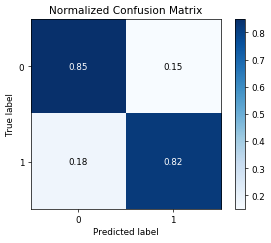

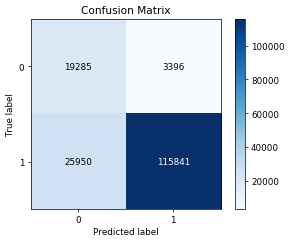

In [99]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, bestC_pred_train_avg_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, bestC_pred_train_avg_w2v_txt)   

IN NOT NORMALIZED FORMAT BELOW


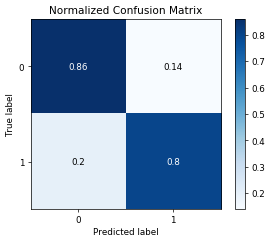

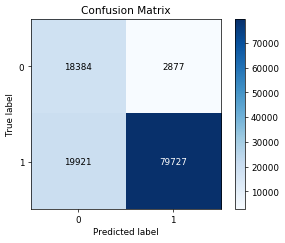

In [100]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, bestC_pred_test_avg_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, bestC_pred_test_avg_w2v_txt)   

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [101]:
from sklearn.linear_model import LogisticRegression
l2_auc_cv_avg_w2v_txt = []
l2_auc_train_avg_w2v_txt=[]


for C in tqdm(C_LR_avf_w2V):
    L2_avg_w2v_txt = LogisticRegression(penalty='l2',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L2_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
    l2_proba_pred_train_avg_w2v_txt=(L2_avg_w2v_txt.predict_proba(sent_vectors_train_l1_std)[:,1])
    l2_proba_pred_cv_avg_w2v_txt=(L2_avg_w2v_txt.predict_proba(sent_vectors_CV_l1_std)[:,1])
    l2_auc_train_avg_w2v_txt.append(roc_auc_score(y_train,l2_proba_pred_train_avg_w2v_txt))
    l2_auc_cv_avg_w2v_txt.append(roc_auc_score(y_CV,l2_proba_pred_cv_avg_w2v_txt))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.85s/it]


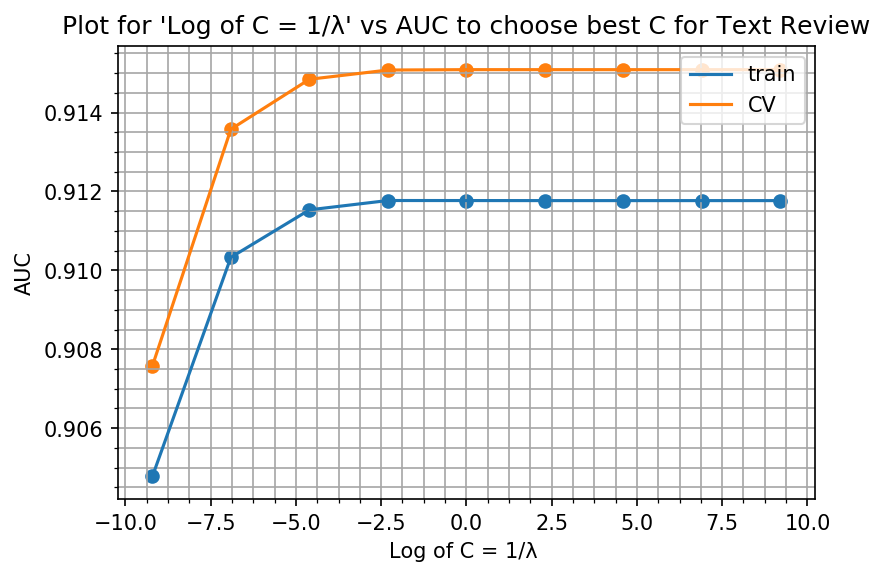

In [102]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_avf_w2V_log, l2_auc_train_avg_w2v_txt)
plt.scatter(C_LR_avf_w2V_log, l2_auc_train_avg_w2v_txt)
plt.plot(C_LR_avf_w2V_log, l2_auc_cv_avg_w2v_txt)
plt.scatter(C_LR_avf_w2V_log, l2_auc_cv_avg_w2v_txt)
plt.xlabel('Log of C = 1/λ ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [103]:
l2_bestC_auc_train_avg_w2v_txt = []
l2_bestC_auc_test_avg_w2v_txt = []
bestC_L2_avg_w2v_txt = LogisticRegression(penalty='l2',C=1, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
bestC_L2_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
l2_bestC_proba_pred_train_avg_w2v_txt=(bestC_L2_avg_w2v_txt.predict_proba(sent_vectors_train_l1_std)[:,1])
l2_bestC_proba_pred_test_avg_w2v_txt=(bestC_L2_avg_w2v_txt.predict_proba(sent_vectors_test_l1_std)[:,1])
l2_bestC_auc_train_avg_w2v_txt.append(roc_auc_score(y_train,l2_bestC_proba_pred_train_avg_w2v_txt))
l2_bestC_auc_test_avg_w2v_txt.append(roc_auc_score(y_test,l2_bestC_proba_pred_test_avg_w2v_txt))


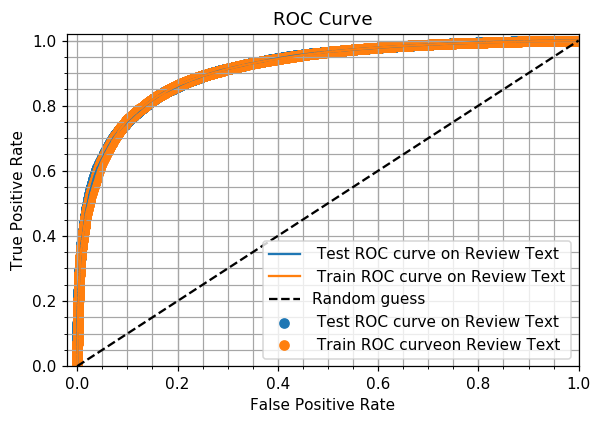

In [104]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avg_w2v_l2_txt, tpr_test_avg_w2v_l2_txt, thresholds = roc_curve(y_test, l2_bestC_proba_pred_test_avg_w2v_txt)
fpr_train_avg_w2v_l2_txt, tpr_train_avg_w2v_l2_txt, thresholds = roc_curve(y_train, l2_bestC_proba_pred_train_avg_w2v_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avg_w2v_l2_txt, tpr_test_avg_w2v_l2_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avg_w2v_l2_txt, tpr_test_avg_w2v_l2_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avg_w2v_l2_txt, tpr_train_avg_w2v_l2_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avg_w2v_l2_txt, tpr_train_avg_w2v_l2_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [105]:
l2_bestC_pred_train_avg_w2v_txt=(bestC_L2_avg_w2v_txt.predict(sent_vectors_train_l1_std))
l2_bestC_pred_test_avg_w2v_txt=(bestC_L2_avg_w2v_txt.predict(sent_vectors_test_l1_std))

In [106]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, l2_bestC_pred_test_avg_w2v_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l2_bestC_pred_train_avg_w2v_txt))

#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.48      0.86      0.62     21261
          1       0.97      0.80      0.87     99648

avg / total       0.88      0.81      0.83    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.43      0.85      0.57     22681
          1       0.97      0.82      0.89    141791

avg / total       0.90      0.82      0.84    164472



IN NOT NORMALIZED FORMAT BELOW


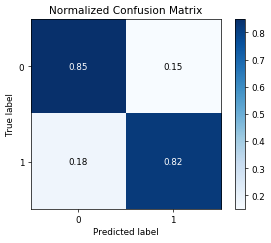

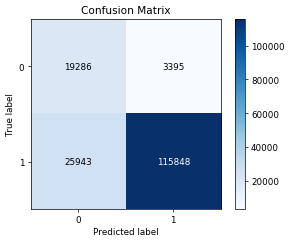

In [107]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l2_bestC_pred_train_avg_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l2_bestC_pred_train_avg_w2v_txt)   

IN NOT NORMALIZED FORMAT BELOW


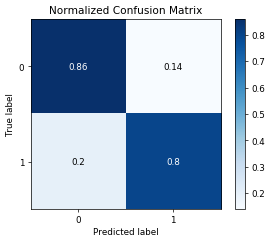

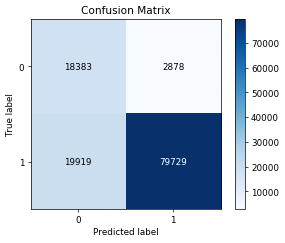

In [108]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l2_bestC_pred_test_avg_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l2_bestC_pred_test_avg_w2v_txt)   

In [109]:
# Please write all the code with proper documentation

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [110]:
model = TfidfVectorizer()
model.fit(X_no_stop_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train and word4 in tfidf_feat:
            vec4 = w2v_model_self_taught_train.wv[word4]
            tf_idf_train = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train)
            weight_sum4 += tf_idf_train
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_train.append(sent_vec4)
    row += 1

100%|████████████████████████████████████████████████████████████████████████| 164472/164472 [4:27:41<00:00, 11.27it/s]


In [111]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train and word5 in tfidf_feat:
            vec5 = w2v_model_self_taught_train.wv[word5]
            tf_idf_test = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test)
            weight_sum5 += tf_idf_test
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_test.append(sent_vec5)
    row += 1

100%|████████████████████████████████████████████████████████████████████████| 120909/120909 [3:26:01<00:00, 17.26it/s]


In [112]:
tfidf_w2v_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent6 in tqdm(lst_of_lst_CV): # for each review/sentence 
    sent_vec6 = np.zeros(50) # as word vectors are of zero length
    weight_sum6 =0; # num of words with a valid vector in the sentence/review
    for word6 in sent6: # for each word in a review/sentence
        if word6 in w2v_words_train and word6 in tfidf_feat:
            vec6 = w2v_model_self_taught_train.wv[word6]
            tf_idf_cv = dictionary[word6]*(sent6.count(word6)/len(sent6))
            sent_vec6 += (vec6 * tf_idf_cv)
            weight_sum6 += tf_idf_cv
    if weight_sum6 != 0:
        sent_vec6 /= weight_sum6
    tfidf_w2v_sent_vectors_cv.append(sent_vec6)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 81009/81009 [2:21:53<00:00, 14.37it/s]


In [113]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

tfidf_w2v_sent_vectors_train_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_train)
tfidf_w2v_sent_vectors_test_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_test)
tfidf_w2v_sent_vectors_cv_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_cv)

In [114]:
def tothepower(y):
    return (10**y)
C_LR_tfidf_w2v = list(map(tothepower, list(range(-4, 5))))
print (C_LR_tfidf_w2v)
C_LR_tfidf_w2v_log = [math.log(x) for x in C_LR_tfidf_w2v]
print (C_LR_tfidf_w2v_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [115]:
from sklearn.linear_model import LogisticRegression
auc_cv_tfidf_w2v_txt = []
auc_train_tfidf_w2v_txt=[]


for C in tqdm(C_LR_tfidf_w2v):
    L1_tfidf_w2v_txt = LogisticRegression(penalty='l1',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L1_tfidf_w2v_txt.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    proba_pred_train_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_train_std)[:,1])
    proba_pred_cv_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_cv_std)[:,1])
    auc_train_tfidf_w2v_txt.append(roc_auc_score(y_train,proba_pred_train_tfidf_w2v_txt))
    auc_cv_tfidf_w2v_txt.append(roc_auc_score(y_CV,proba_pred_cv_tfidf_w2v_txt))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:33<00:00, 12.75s/it]


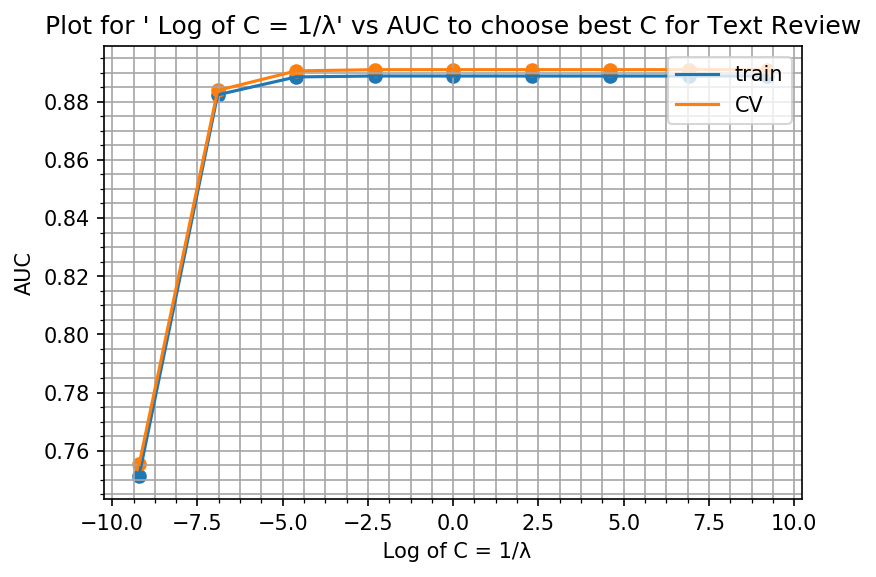

In [116]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_tfidf_w2v_log, auc_train_tfidf_w2v_txt)
plt.scatter(C_LR_tfidf_w2v_log, auc_train_tfidf_w2v_txt)
plt.plot(C_LR_tfidf_w2v_log, auc_cv_tfidf_w2v_txt)
plt.scatter(C_LR_tfidf_w2v_log, auc_cv_tfidf_w2v_txt)
plt.xlabel(' Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for ' Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### The value of C is 1 for TFIDF W2V 

In [117]:
l1_bestC_auc_train_tfidf_w2v_txt = []
l1_bestC_auc_test_tfidf_w2v_txt = []
L1_tfidf_w2v_txt = LogisticRegression(penalty='l1',C=1, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
L1_tfidf_w2v_txt.fit(tfidf_w2v_sent_vectors_train_std, y_train)
proba_pred_train_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_train_std)[:,1])
proba_pred_test_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_test_std)[:,1])

l1_bestC_auc_train_tfidf_w2v_txt.append(roc_auc_score(y_train,proba_pred_train_tfidf_w2v_txt))
l1_bestC_auc_test_tfidf_w2v_txt.append(roc_auc_score(y_test,proba_pred_test_tfidf_w2v_txt))

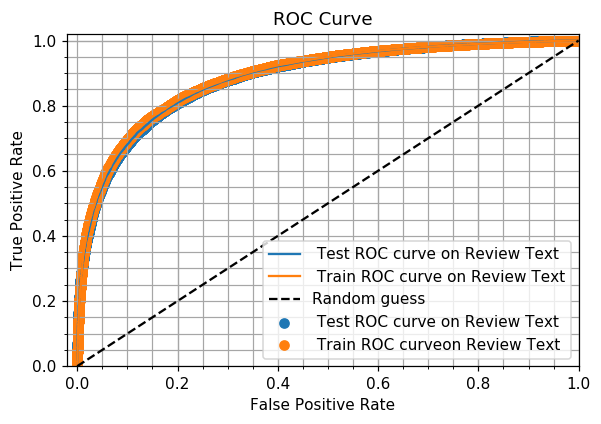

In [118]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avg_tfidf_l1_txt, tpr_test_avg_tfidf_l1_txt, thresholds = roc_curve(y_test, proba_pred_test_tfidf_w2v_txt)
fpr_train_avg_tfidf_l1_txt, tpr_train_avg_tfidf_l1_txt, thresholds = roc_curve(y_train, proba_pred_train_tfidf_w2v_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avg_tfidf_l1_txt, tpr_test_avg_tfidf_l1_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avg_tfidf_l1_txt, tpr_test_avg_tfidf_l1_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avg_tfidf_l1_txt, tpr_train_avg_tfidf_l1_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avg_tfidf_l1_txt, tpr_train_avg_tfidf_l1_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [119]:
l1_pred_train_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict(tfidf_w2v_sent_vectors_train_std))
l1_pred_test_tfidf_w2v_txt=(L1_tfidf_w2v_txt.predict(tfidf_w2v_sent_vectors_test_std))

In [120]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, l1_pred_test_tfidf_w2v_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l1_pred_train_tfidf_w2v_txt))


#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.45      0.83      0.58     21261
          1       0.96      0.78      0.86     99648

avg / total       0.87      0.79      0.81    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.39      0.82      0.53     22681
          1       0.97      0.79      0.87    141791

avg / total       0.89      0.80      0.82    164472



IN NOT NORMALIZED FORMAT BELOW


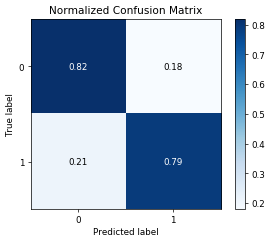

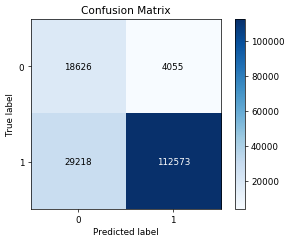

In [121]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l1_pred_train_tfidf_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l1_pred_train_tfidf_w2v_txt)   

IN NOT NORMALIZED FORMAT BELOW


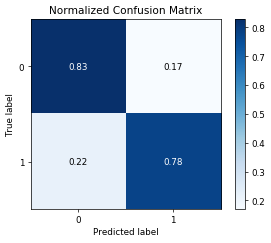

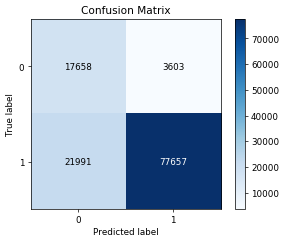

In [122]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l1_pred_test_tfidf_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l1_pred_test_tfidf_w2v_txt)   

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [123]:
from sklearn.linear_model import LogisticRegression
l2_auc_cv_tfidf_w2v_txt = []
L2_auc_train_tfidf_w2v_txt=[]


for C in tqdm(C_LR_tfidf_w2v):
    L2_tfidf_w2v_txt = LogisticRegression(penalty='l2',C=C, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
    L2_tfidf_w2v_txt.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    l2_proba_pred_train_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_train_std)[:,1])
    L2_proba_pred_cv_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_cv_std)[:,1])
    L2_auc_train_tfidf_w2v_txt.append(roc_auc_score(y_train,l2_proba_pred_train_tfidf_w2v_txt))
    l2_auc_cv_tfidf_w2v_txt.append(roc_auc_score(y_CV,L2_proba_pred_cv_tfidf_w2v_txt))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  3.04s/it]


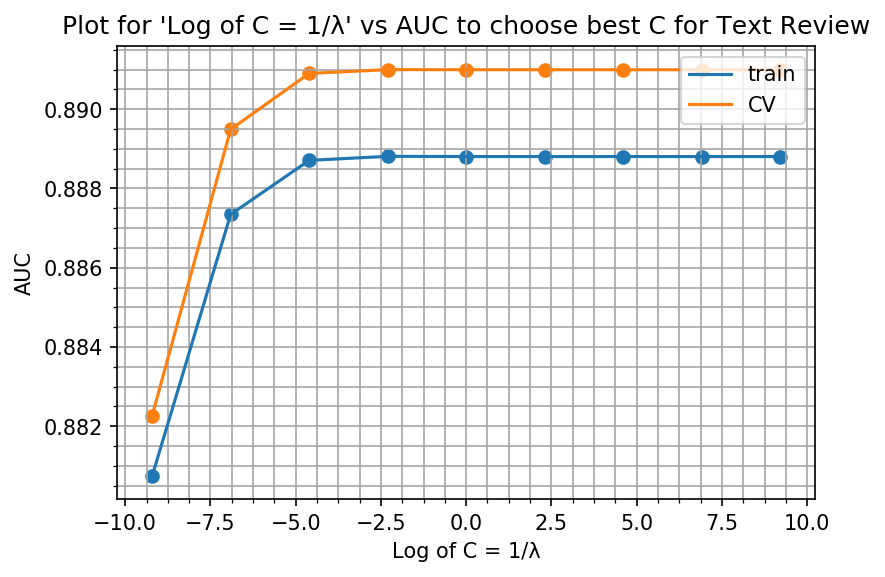

In [124]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(C_LR_tfidf_w2v_log, L2_auc_train_tfidf_w2v_txt)
plt.scatter(C_LR_tfidf_w2v_log, L2_auc_train_tfidf_w2v_txt)
plt.plot(C_LR_tfidf_w2v_log, l2_auc_cv_tfidf_w2v_txt)
plt.scatter(C_LR_tfidf_w2v_log, l2_auc_cv_tfidf_w2v_txt)
plt.xlabel('Log of C = 1/λ')
plt.ylabel('AUC')
plt.title("Plot for 'Log of C = 1/λ' vs AUC to choose best C for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [125]:
l2_bestC_auc_train_tfidf_w2v_txt = []
l2_bestC_auc_test_tfidf_w2v_txt = []

L2_tfidf_w2v_txt = LogisticRegression(penalty='l2',C=1, fit_intercept=True, intercept_scaling=1, class_weight='balanced')
L2_tfidf_w2v_txt.fit(tfidf_w2v_sent_vectors_train_std, y_train)
l2_proba_pred_train_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_train_std)[:,1])
l2_proba_pred_test_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict_proba(tfidf_w2v_sent_vectors_test_std)[:,1])

l2_bestC_auc_train_tfidf_w2v_txt.append(roc_auc_score(y_train,l2_proba_pred_train_tfidf_w2v_txt))
l2_bestC_auc_test_tfidf_w2v_txt.append(roc_auc_score(y_test,l2_proba_pred_test_tfidf_w2v_txt))

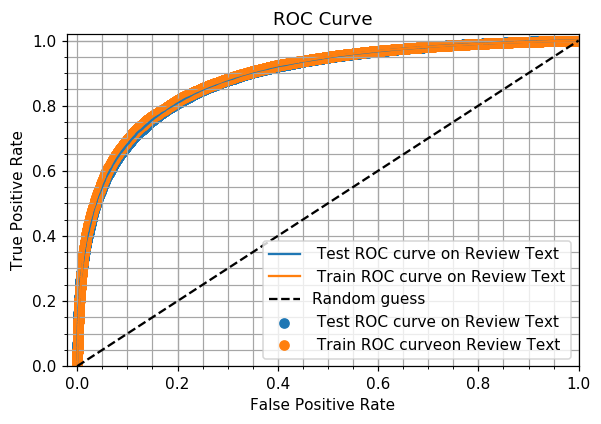

In [126]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avg_tfidf_l2_txt, tpr_test_avg_tfidf_l2_txt, thresholds = roc_curve(y_test, l2_proba_pred_test_tfidf_w2v_txt)
fpr_train_avg_tfidf_l2_txt, tpr_train_avg_tfidf_l2_txt, thresholds = roc_curve(y_train, l2_proba_pred_train_tfidf_w2v_txt)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avg_tfidf_l2_txt, tpr_test_avg_tfidf_l2_txt, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avg_tfidf_l2_txt, tpr_test_avg_tfidf_l2_txt, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avg_tfidf_l2_txt, tpr_train_avg_tfidf_l2_txt, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avg_tfidf_l2_txt, tpr_train_avg_tfidf_l2_txt, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [127]:
l2_pred_train_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict(tfidf_w2v_sent_vectors_train_std))
l2_pred_test_tfidf_w2v_txt=(L2_tfidf_w2v_txt.predict(tfidf_w2v_sent_vectors_test_std))

In [128]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")
print(classification_report(y_test, l2_pred_test_tfidf_w2v_txt))
print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, l2_pred_train_tfidf_w2v_txt))


#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.45      0.83      0.58     21261
          1       0.96      0.78      0.86     99648

avg / total       0.87      0.79      0.81    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.39      0.82      0.53     22681
          1       0.97      0.79      0.87    141791

avg / total       0.89      0.80      0.82    164472



IN NOT NORMALIZED FORMAT BELOW


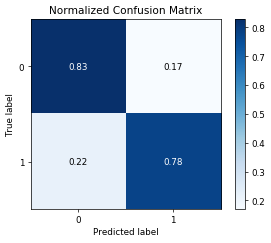

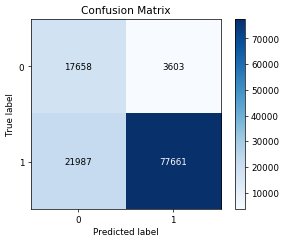

In [129]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test, l2_pred_test_tfidf_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_test, l2_pred_test_tfidf_w2v_txt)   

IN NOT NORMALIZED FORMAT BELOW


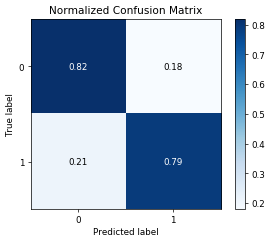

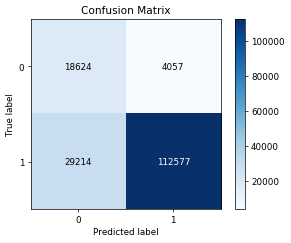

In [130]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train, l2_pred_train_tfidf_w2v_txt,normalize=True)
print ("IN NOT NORMALIZED FORMAT BELOW")
skplt.plot_confusion_matrix(y_train, l2_pred_train_tfidf_w2v_txt)   

# [6] Conclusions

In [131]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Hyper-Parameter C = 1/λ", "AUC"]

x.add_row(["Bag Of Words with L1 (Test Data)",.16,l1_auc_test_BOW ])
x.add_row(["Bag Of Words with L1 (Train Data)",.16,l1_auc_train_BOW ])
x.add_row(["Bag Of Words with L2 (Test Data)",.06,l2_auc_test_BOW ])
x.add_row(["Bag Of Words with L2 (Train Data)",.06,l2_auc_train_BOW])
x.add_row(["TFIDF with L1 (Test Data)",6,l1_auc_test_tfidf ])
x.add_row(["TFIDF with L1 (Train Data)",6,l1_auc_train_tfidf ])
x.add_row(["TFIDF with L2 (Test Data)",10000,l2_auc_test_tfidf ])
x.add_row(["TFIDF with L2 (Train Data)",10000,l2_auc_train_tfidf ])
x.add_row(["Avg-W2V with L1 (Test Data)",1, bestCl1_auc_test_avg_w2v_txt])
x.add_row(["Avg-W2V with L1 (Train Data)",1,bestCl1_auc_train_avg_w2v_txt ])
x.add_row(["Avg-W2V with L2 (Test)",1,l2_bestC_auc_test_avg_w2v_txt ])
x.add_row(["TFIDF-W2V with L2 (Train)",1,l2_bestC_auc_train_avg_w2v_txt ])
x.add_row(["TFIDF-W2V with L1 (Test Data)",1,l1_bestC_auc_test_tfidf_w2v_txt ])
x.add_row(["TFIDF-W2V with L1 (Train Data)",1,l1_bestC_auc_train_tfidf_w2v_txt ])
x.add_row(["TFIDF-W2V with L2 (Test)",1, l2_bestC_auc_test_tfidf_w2v_txt])
x.add_row(["TFIDF-W2V with L2 (Train)",1, l2_bestC_auc_train_tfidf_w2v_txt])

print (x)

+-----------------------------------+-------------------------+----------------------+
|             Algorithm             | Hyper-Parameter C = 1/λ |         AUC          |
+-----------------------------------+-------------------------+----------------------+
|  Bag Of Words with L1 (Test Data) |           0.16          |  0.9422061600108804  |
| Bag Of Words with L1 (Train Data) |           0.16          |  0.9595183466662653  |
|  Bag Of Words with L2 (Test Data) |           0.06          |  0.9560466630696771  |
| Bag Of Words with L2 (Train Data) |           0.06          |  0.9760106097669967  |
|     TFIDF with L1 (Test Data)     |            6            |  0.9672281379423163  |
|     TFIDF with L1 (Train Data)    |            6            |  0.993729950925152   |
|     TFIDF with L2 (Test Data)     |          10000          |  0.9668719764414065  |
|     TFIDF with L2 (Train Data)    |          10000          |  0.9999999992226276  |
|    Avg-W2V with L1 (Test Data)    |      

### Both TFIDF and BOW performed very good. Also it didnt take much time. Also they were better than previous algorithms that we tried like KNN and Naive Bayes
### Avg-W2V and TFIDF-W2V takes time in creating model and also it didnt perform that well as compared to Logistic Regression of BOW andTFIDF

### <font color='red'>Also as mentioned before we saw the features are very collinear after introducing small noise we can see the TPR and FPR wasnt that much affected for training dataset as compared with TPR and FPR after introduction of noise </font>